# Virgo: base line Modeling

starting

## Libraries

In [1]:
import configs, datafunction, modeling, crossvalidation
import datetime
import tensorflow as tf
import numpy as np
import optuna
import os

import re

import mlflow
from pathlib import Path
from  mlflow.tracking import MlflowClient
from mlflow.models.signature import infer_signature

### required for plt show in fastapi
### import io
### import matplotlib
### matplotlib.use('AGG')
### import matplotlib.pyplot as plt

import time

In [2]:
import yfinance as yf
import pandas as pd

import datetime
from dateutil.relativedelta import relativedelta

import plotly.offline as pyo
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [3]:
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns; sns.set()

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

import plotly.express as px
import plotly.offline as pyo

In [4]:
import mlflow
from pathlib import Path
from  mlflow.tracking import MlflowClient
from mlflow.models.signature import infer_signature
import mlflow.pyfunc

In [5]:
tf.__version__

'2.11.0'

In [6]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

## Configs

In [7]:
today_str = datetime.date.today().strftime("%Y-%m-%d")

n_days = configs.data_configs.n_days
lag_days = configs.data_configs.lags
window = configs.data_configs.window

split_config = configs.data_configs.split_config
drop_columns = configs.data_configs.drop_columns
OUT_STEPS = configs.data_configs.steps_to_predic
best_error_global = configs.data_configs.best_error
save_predictions_path = configs.data_configs.save_predictions_path
save_model_path = configs.data_configs.save_model_path


In [8]:
OUT_STEPS = 7
input_length = 20
n_trials_baseline = 10
n_trials_deepdive = 40
#hyperparameter
lag_days = 3
stock_code = 'AMD'

In [9]:
lag_days, input_length, OUT_STEPS

(3, 20, 7)

## Transformations

In [10]:
class run_supermodel():
    
    def __init__(self, stock_code, OUT_STEPS , train_predict_bool = False, cross_validation = False, n_trials_baseline = 1,n_trials_deepdive = 1, save_model = False):
        self.stock_code = stock_code
        self.train_predict_bool = train_predict_bool
        self.n_trials_baseline = n_trials_baseline
        self.n_trials_deepdive = n_trials_deepdive
        self.cross_validation = cross_validation
        self.save_model = save_model
        
        ### some configs to save the model and study
#         model_and_study_path = f'{save_model_path}/{today_str}/'

#         if not os.path.exists(model_and_study_path):
#             os.makedirs(model_and_study_path)

#         self.path_best_model = f'{model_and_study_path}/{self.stock_code}-best_model.h5'
#         self.study_name = f"{model_and_study_path}/{self.stock_code}-model_study"  # unique identifier of the study.
#         self.storage_name = "sqlite:///{}.db".format(self.study_name)

        self.predictions_path_file = f'{save_predictions_path}/{today_str}-{self.stock_code}-predictions.csv'

In [11]:
run_supermodel_tmp = run_supermodel(stock_code = stock_code, OUT_STEPS= OUT_STEPS, train_predict_bool = True, cross_validation = True, n_trials_baseline = n_trials_baseline,n_trials_deepdive = n_trials_deepdive , save_model = True)

In [12]:
def get_basic_feaures(self,prefix, n_days, window):
    
    self.prefix = prefix
    
    today = datetime.date.today()
    begin_date = today - relativedelta(days = n_days)
    begin_date_str = begin_date.strftime('%Y-%m-%d')
    
    stock = yf.Ticker(self.stock_code)
    df = stock.history(period="max")
    df = df.sort_values('Date')
    df.reset_index(inplace=True)
    
    ### getting rolling stdv
    df["Close_roll_std"] = (
        df.sort_values("Date")["Close"]
        .transform(lambda x: x.rolling(window, min_periods=1).std())
    )
    
    ### applying smoothing
    smoother = ExponentialSmoothing(df.Close)
    df['smoothed_Close'] = smoother.fit(smoothing_level=0.3,smoothing_trend=0.1,smoothing_seasonal=0, optimized=False).fittedvalues
    
    df = df[df.Date >= begin_date_str ]
    
    data = df[['Date','Close', 'Close_roll_std', 'Volume', 'smoothed_Close']]
    data = data.rename(columns = {
        'Close': f'{self.prefix}_price',
        "Close_roll_std": f'{self.prefix}_stv',
        'Volume':f'{self.prefix}_Volume',
        'Close_roll_mean':f'{self.prefix}_roll_mean'
    })
    data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d',utc=True)
    data['Date'] = pd.to_datetime(data['Date']).dt.date
    
    self.raw_data = data

In [13]:
run_supermodel.get_basic_feaures = get_basic_feaures

In [14]:
def data_features_eng(self):
    
    std_col = [ x for x in self.raw_data.columns if '_stv' in x ][0]
    volume_col = [ x for x in self.raw_data.columns if '_Volume' in x ][0]
    
    self.raw_data["roll_std"] = self.raw_data.sort_index()[std_col].transform(lambda x: x.rolling(10, min_periods=1).mean())
    self.raw_data['log_Volume'] = np.log(self.raw_data[volume_col])
    self.raw_data["roll_log_Volume"] = self.raw_data.sort_index()['log_Volume'].transform(lambda x: x.rolling(5, min_periods=1).mean())
    self.raw_data['noise_price'] = self.raw_data.smoothed_Close - self.raw_data.stock_price
    
    self.raw_data = (
            self.raw_data
            .assign(count_pos_noise = np.where(self.raw_data.noise_price > 0, 1,0))
            .assign(count_neg_noise = np.where(self.raw_data.noise_price <= 0, 1,0))
        )
    self.raw_data["roll_pos_noise_count"] = self.raw_data.sort_values('Date')["count_pos_noise"].transform(lambda x: x.rolling(10, min_periods=1).sum())
    self.raw_data["roll_neg_noise_count"] = self.raw_data.sort_values('Date')["count_neg_noise"].transform(lambda x: x.rolling(10, min_periods=1).sum())
    self.raw_data = self.raw_data.drop(columns = ['count_pos_noise', 'count_neg_noise'])
    
    
    def measure_distance(data, roll_scope, typex):

        if typex =='max':
            data["dist"] = data.sort_values('Date')['smoothed_Close'].transform(lambda x: x.rolling(roll_scope, min_periods=1).max())
        elif typex == 'min':
            data["dist"] = data.sort_values('Date')['smoothed_Close'].transform(lambda x: x.rolling(roll_scope, min_periods=1).min())

        data["dist_tmp"] = 0

        for i in range(len(data)):
            dist_ref = data.iloc[i,data.columns.get_loc("dist")]
            for j in range(0 if i-roll_scope <= 0 else i-roll_scope, i+1 ):

                ref_value = data.iloc[j,data.columns.get_loc("smoothed_Close")]
                if ref_value == dist_ref:
                    date_ref = data.iloc[j,data.columns.get_loc("Date")]
                    data.iloc[i,data.columns.get_loc("dist_tmp")] = date_ref
                    continue

        data[f'dist_{typex}'] =  pd.to_numeric((data['Date'] - data['dist_tmp']).dt.days,downcast='float')
        data = data.drop(columns = ['dist','dist_tmp'])

        return data
    
    self.raw_data = measure_distance(data = self.raw_data, roll_scope = 10, typex = 'max')
    self.raw_data = measure_distance(data = self.raw_data, roll_scope = 10, typex = 'min')
    

In [15]:
run_supermodel.data_features_eng = data_features_eng

In [16]:
def data_target_features_eng(self, lags, list_lags = [30]):
    
    self.target_data = self.raw_data
    
    price = [ x for x in self.target_data.columns if '_price' in x ][0]
    
    self.target_data['lag'] = self.target_data.stock_price.shift(lags)
    self.target_data[f'{self.prefix}_logdif'] = np.log(self.target_data[price]) - np.log(self.target_data['lag'])
    
    self.target_data = self.target_data.rename(columns = {'Close': f'{self.prefix}_price'})
    target = f'{self.prefix}_logdif'
    
    self.target_data = (
        self.target_data
        .sort_values('Date')
        .set_index('Date')
        .assign(up_yield = np.where(self.target_data[target] > 0, 1,0))
        .assign(low_yield = np.where(self.target_data[target] <= 0, 1,0))
    )
    ## rolling operations
    self.target_data["roll_up_yield"] = self.target_data.sort_index()["up_yield"].transform(lambda x: x.rolling(3, min_periods=1).sum())
    self.target_data["roll_low_yield"] = self.target_data.sort_index()["low_yield"].transform(lambda x: x.rolling(3, min_periods=1).sum())
    self.target_data[f"roll_{target}"] = self.target_data.sort_index()[target].transform(lambda x: x.rolling(3, min_periods=1).mean())
    
    ## getting lags
    if list_lags:
        lags = list_lags
        columns_to_lag = [target,f"roll_{target}","roll_up_yield", "roll_low_yield"]

        for lag_ in lags:
            for col_ in columns_to_lag:
                self.target_data[f'lag_{lag_}_{col_}'] = self.target_data[col_].shift(lag_)
    
    ## some cleaning
    self.target_data = (
        self.target_data
        .drop(columns = [price,'stock_stv','stock_Volume','lag','up_yield', 'low_yield','log_Volume','noise_price'])
        .dropna(axis='rows')
        .sort_index()
    )

In [17]:
run_supermodel.data_target_features_eng = data_target_features_eng

In [18]:
run_supermodel_tmp.get_basic_feaures(prefix = 'stock', n_days = n_days, window = window)
run_supermodel_tmp.data_features_eng()

In [19]:
run_supermodel_tmp.raw_data.head()

,Date,stock_price,stock_stv,stock_Volume,smoothed_Close,roll_std,log_Volume,roll_log_Volume,noise_price,roll_pos_noise_count,roll_neg_noise_count,dist_max,dist_min
10181,2020-07-31,77.430000,6.682071,71621600,71.273932,6.682071,18.086907,18.086907,-6.156068,0.0,1.0,0.0,0.0
10182,2020-08-03,77.669998,4.717815,42628800,73.120753,5.699943,17.568041,17.827474,-4.549246,0.0,2.0,0.0,3.0
10183,2020-08-04,85.040001,5.931223,155676100,74.485526,5.777036,18.863288,18.172745,-10.554475,0.0,3.0,0.0,4.0
10184,2020-08-05,85.309998,5.983468,65642600,77.651869,5.828644,17.999735,18.129493,-7.658129,0.0,4.0,0.0,5.0
10185,2020-08-06,86.709999,4.532117,53961700,79.949307,5.569339,17.803785,18.064351,-6.760692,0.0,5.0,0.0,6.0


In [20]:
run_supermodel_tmp.data_target_features_eng(lags = lag_days)

In [21]:
run_supermodel_tmp.target_data.head(5)

,smoothed_Close,roll_std,roll_log_Volume,roll_pos_noise_count,roll_neg_noise_count,dist_max,dist_min,stock_logdif,roll_up_yield,roll_low_yield,roll_stock_logdif,lag_30_stock_logdif,lag_30_roll_stock_logdif,lag_30_roll_up_yield,lag_30_roll_low_yield
Date,,,,,,,,,,,,,,,
2020-09-17,78.513517,3.661654,17.732981,10.0,0.0,14.0,0.0,-0.017482,1.0,2.0,-0.004644,0.096917,0.096917,1.0,0.0
2020-09-18,77.924463,3.435372,17.719068,10.0,0.0,14.0,0.0,-0.052007,1.0,2.0,-0.021769,0.110100,0.103509,2.0,0.0
2020-09-21,77.026124,3.142239,17.770334,9.0,1.0,13.0,0.0,0.016559,1.0,2.0,-0.017643,-0.002237,0.068260,2.0,1.0
2020-09-22,77.300288,2.754619,17.763909,8.0,2.0,13.0,1.0,0.014911,2.0,1.0,-0.006846,-0.036650,0.023738,1.0,2.0
2020-09-23,77.420200,2.369422,17.783418,8.0,2.0,13.0,2.0,-0.002673,2.0,1.0,0.009599,-0.120323,-0.053070,0.0,3.0


In [22]:
run_supermodel_tmp.target_data.columns

Index(['smoothed_Close', 'roll_std', 'roll_log_Volume', 'roll_pos_noise_count',
       'roll_neg_noise_count', 'dist_max', 'dist_min', 'stock_logdif',
       'roll_up_yield', 'roll_low_yield', 'roll_stock_logdif',
       'lag_30_stock_logdif', 'lag_30_roll_stock_logdif',
       'lag_30_roll_up_yield', 'lag_30_roll_low_yield'],
      dtype='object')

<b> splitting data

In [23]:
split_object = datafunction.split_data(run_supermodel_tmp.target_data, split_config)

In [24]:
column_indices = split_object.column_indices
n = split_object.ndata
train_df = split_object.train_df
val_df  = split_object.val_df
test_df = split_object.test_df
num_features = split_object.num_features

In [25]:
split_object.scaling()
train_mean = split_object.train_mean
train_std = split_object.train_std
train_df = split_object.train_df
val_df  = split_object.val_df
test_df = split_object.test_df

<b> window generator

In [26]:
input_length,OUT_STEPS, run_supermodel_tmp.target_data.shape

(20, 7, (622, 15))

In [27]:
wide_window = datafunction.WindowGenerator(
            total_data = run_supermodel_tmp.target_data, 
            raw_stock = run_supermodel_tmp.raw_data,
            train_df=train_df, 
            val_df=val_df, 
            test_df=test_df,
            input_width=input_length, 
            label_width=OUT_STEPS, 
            shift=OUT_STEPS,
            label_columns=['stock_logdif']
        )

In [28]:
# Stack three slices, the length of the total window some selections
example_window = tf.stack(
    [np.array(train_df[:wide_window.total_window_size]),
    np.array(train_df[20:20+wide_window.total_window_size]),
    np.array(train_df[50:50+wide_window.total_window_size]),
    np.array(train_df[90:90+wide_window.total_window_size]),
    np.array(train_df[120:120+wide_window.total_window_size]),
    np.array(train_df[150:150+wide_window.total_window_size]),
    ]
)

In [29]:
example_inputs, example_labels = wide_window.split_window(example_window)

In [30]:
def plot(self, model=None, plot_col='stock_logdif', max_subplots=4):
    inputs, labels = example_inputs, example_labels
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(max_n, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                 label='Inputs', marker='.', zorder=-10)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
        
        if model is not None:
            predictions = model(inputs)
            plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                        marker='X', edgecolors='k', label='Predictions',
                        c='#ff7f0e', s=64)

        if n == 0:
            plt.legend()
            
        plt.axhline(0.0, linestyle='--', color = 'pink')

    plt.xlabel('Time [d]')

In [31]:
datafunction.WindowGenerator.plot = plot ## do not include

In [32]:
def plot_test(self, model, plot_col='stock_logdif', max_subplots = 4, take_ =1):
    
    sample_test = self.test.take(take_)
    for input_,label in sample_test:
        numpy_input = input_.numpy()
        numpy_labels = label.numpy()
        
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(numpy_input))
    
    for n in range(max_n):
        plt.subplot(max_n, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, numpy_input[n, :, plot_col_index],
                 label='Inputs', marker='.', zorder=-10)
        
        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue
            
        plt.scatter(self.label_indices, numpy_labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
        
        predictions = model(numpy_input)
        plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                        marker='X', edgecolors='k', label='Predictions',
                        c='#ff7f0e', s=64)
        if n == 0:
            plt.legend()
        plt.axhline(0.0, linestyle='--', color = 'pink')
    plt.xlabel('Time [d]')

In [33]:
datafunction.WindowGenerator.plot_test = plot_test ## do not include

<b> base line models

In [34]:
class initial_models():
    def __init__(self, OUT_STEPS, num_features, CONV_WIDTH = 3):

        self.multi_linear_model = tf.keras.Sequential([
            # Take the last time-step.
            # Shape [batch, time, features] => [batch, 1, features]
            tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
            # Shape => [batch, 1, out_steps*features]
            tf.keras.layers.Dense(OUT_STEPS*num_features,
                                kernel_initializer=tf.initializers.zeros()),
            # Shape => [batch, out_steps, features]
            tf.keras.layers.Reshape([OUT_STEPS, num_features])
        ])

        self.multi_dense_model =tf.keras.Sequential([
            # Take the last time step.
            # Shape [batch, time, features] => [batch, 1, features]
            tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
            # Shape => [batch, 1, dense_units]
            tf.keras.layers.Dense(512, activation='relu'),
            # Shape => [batch, out_steps*features]
            tf.keras.layers.Dense(OUT_STEPS*num_features,
                                kernel_initializer=tf.initializers.zeros()),
            # Shape => [batch, out_steps, features]
            tf.keras.layers.Reshape([OUT_STEPS, num_features])
        ])

        self.multi_conv_model = tf.keras.Sequential([
            # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
            tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
            # Shape => [batch, 1, conv_units]
            tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
            # Shape => [batch, 1,  out_steps*features]
            tf.keras.layers.Dense(OUT_STEPS*num_features,
                                kernel_initializer=tf.initializers.zeros()),
            # Shape => [batch, out_steps, features]
            tf.keras.layers.Reshape([OUT_STEPS, num_features])
        ])

        self.multi_lstm_model = tf.keras.Sequential([
            # Shape [batch, time, features] => [batch, lstm_units].
            # Adding more `lstm_units` just overfits more quickly.
            tf.keras.layers.LSTM(32, return_sequences=False),
            # Shape => [batch, out_steps*features].
            tf.keras.layers.Dense(OUT_STEPS*num_features,
                                kernel_initializer=tf.initializers.zeros()),
            # Shape => [batch, out_steps, features].
            tf.keras.layers.Reshape([OUT_STEPS, num_features])
        ])

        ### autoregresive model
        class FeedBack(tf.keras.Model):
            def __init__(self, units, out_steps):
                super().__init__()
                self.out_steps = out_steps
                self.units = units
                self.lstm_cell = tf.keras.layers.LSTMCell(units)
                # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
                self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
                self.dense = tf.keras.layers.Dense(num_features)

            def warmup(self, inputs):
                # inputs.shape => (batch, time, features)
                # x.shape => (batch, lstm_units)
                x, *state = self.lstm_rnn(inputs)

                # predictions.shape => (batch, features)
                prediction = self.dense(x)
                return prediction, state

            def call(self, inputs, training=None):
                # Use a TensorArray to capture dynamically unrolled outputs.
                predictions = []
                # Initialize the LSTM state.
                prediction, state = self.warmup(inputs)

                # Insert the first prediction.
                predictions.append(prediction)

                # Run the rest of the prediction steps.
                for n in range(1, self.out_steps):
                    # Use the last prediction as input.
                    x = prediction
                    # Execute one lstm step.
                    x, state = self.lstm_cell(x, states=state,
                                            training=training)
                    # Convert the lstm output to a prediction.
                    prediction = self.dense(x)
                    # Add the prediction to the output.
                    predictions.append(prediction)

                # predictions.shape => (time, batch, features)
                predictions = tf.stack(predictions)
                # predictions.shape => (batch, time, features)
                predictions = tf.transpose(predictions, [1, 0, 2])
                
                return predictions

        self.feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

In [35]:
def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanSquaredError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping],
                       verbose = 0)
    return history

In [36]:
multi_val_performance = {}
multi_performance = {}
best_model_framework = None
best_error_study = None

In [37]:
MAX_EPOCHS = 20

In [38]:
multi_linear_model = initial_models(OUT_STEPS, num_features).multi_linear_model
history = compile_and_fit(multi_linear_model, wide_window)
multi_val_performance['Linear'] = multi_linear_model.evaluate(wide_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(wide_window.test, verbose=0)

multi_dense_model = initial_models(OUT_STEPS, num_features).multi_linear_model
history = compile_and_fit(multi_dense_model, wide_window)
multi_val_performance['Dense'] = multi_dense_model.evaluate(wide_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(wide_window.test, verbose=0)

multi_conv_model = initial_models(OUT_STEPS, num_features).multi_conv_model
history = compile_and_fit(multi_conv_model, wide_window)
multi_val_performance['Conv'] = multi_conv_model.evaluate(wide_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(wide_window.test, verbose=0)

multi_lstm_model = initial_models(OUT_STEPS, num_features).multi_lstm_model
history = compile_and_fit(multi_lstm_model, wide_window)
multi_val_performance['LSTM'] = multi_lstm_model.evaluate(wide_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(wide_window.test, verbose=0)

feedback_model = initial_models(OUT_STEPS, num_features).feedback_model
history = compile_and_fit(feedback_model, wide_window)
multi_val_performance['AR LSTM'] = feedback_model.evaluate(wide_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(wide_window.test, verbose=0)

4/4 [==============================] - 0s 6ms/step - loss: 1.9652 - mean_squared_error: 1.9652


In [39]:
miguel_lstm_model = tf.keras.Sequential([
            # Shape [batch, time, features] => [batch, lstm_units].
            # Adding more `lstm_units` just overfits more quickly
            tf.keras.layers.LSTM(50, return_sequences=True),
            tf.keras.layers.LSTM(32, return_sequences=True),
            tf.keras.layers.LSTM(32, return_sequences=False),
            # Shape => [batch, out_steps*features].
            tf.keras.layers.Dense(OUT_STEPS*num_features,
                                kernel_initializer=tf.initializers.zeros()),
            # Shape => [batch, out_steps, features].
            tf.keras.layers.Reshape([OUT_STEPS, num_features])
        ])

history = compile_and_fit(miguel_lstm_model, wide_window)
multi_val_performance['miguel model'] = miguel_lstm_model.evaluate(wide_window.val)
multi_performance['miguel model'] = miguel_lstm_model.evaluate(wide_window.test, verbose=0)


4/4 [==============================] - 0s 10ms/step - loss: 1.9623 - mean_squared_error: 1.9623


In [40]:
### base line models error

metric_name = 'mean_squared_error'
metric_index = multi_linear_model.metrics_names.index(metric_name)
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

best_model_framework =list(multi_performance.keys())[np.argmin(test_mae)]

###storing first training results ### to save in memory
best_model_framework =list(multi_performance.keys())[np.argmin(test_mae)]
baseline_validation_results = dict(zip(multi_performance.keys(), val_mae))
baseline_test_results = dict(zip(multi_performance.keys(), test_mae))

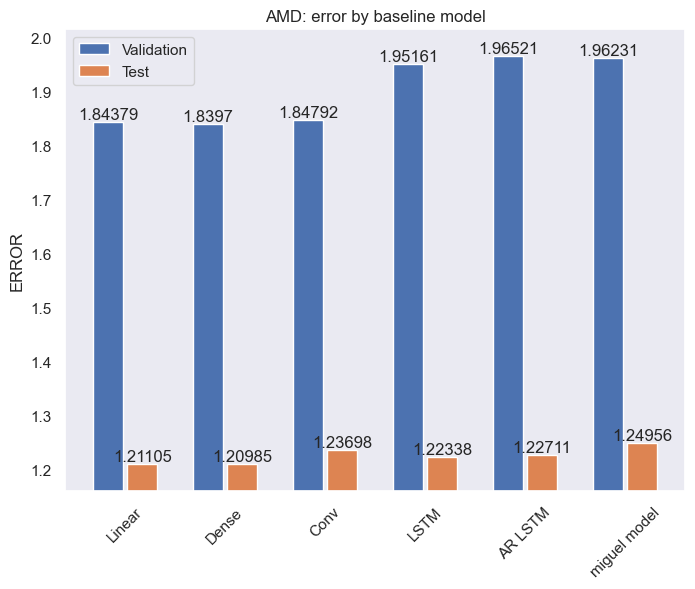

In [41]:
x = np.arange(len(multi_performance))
width = 0.3

fig, ax = plt.subplots()

p1 = ax.bar(x - 0.17, val_mae, width, label='Validation')
p2 = ax.bar(x + 0.17, test_mae, width, label='Test')

ax.set_xticks(ticks=x, labels=multi_performance.keys(),
        rotation=45)
ax.set_ylabel(f'ERROR')
ax.bar_label(p1, label_type='edge')
ax.bar_label(p2, label_type='edge')

ax.set_ylim(min(val_mae + test_mae)-0.05, max(val_mae + test_mae) + 0.05)
_ = plt.legend()
plt.title(f'{stock_code}: error by baseline model')
fig.show()

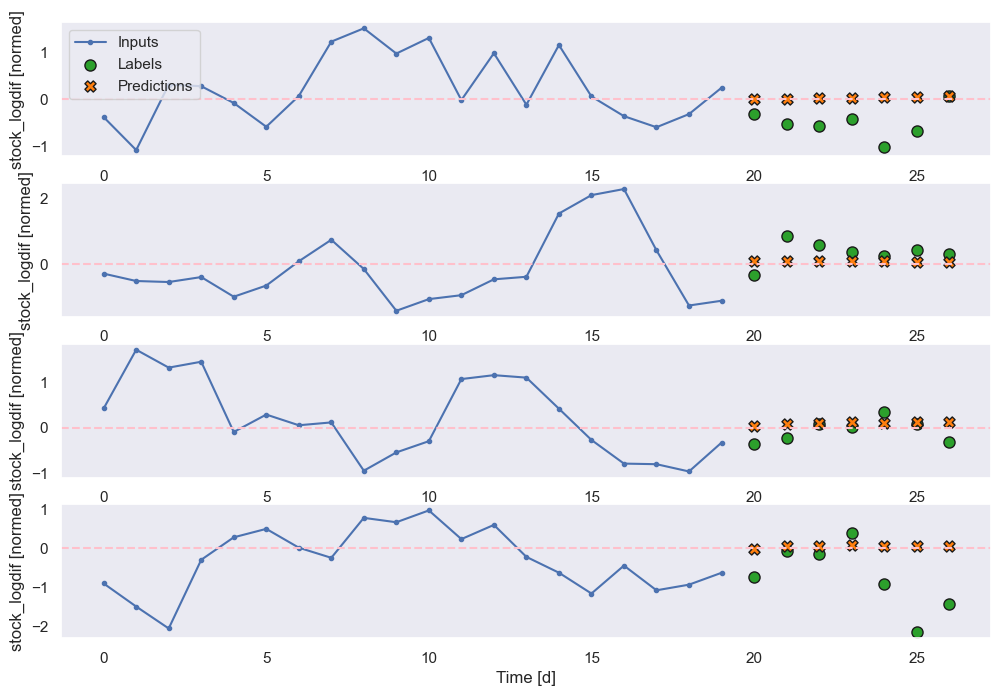

In [42]:
wide_window.plot(multi_lstm_model)

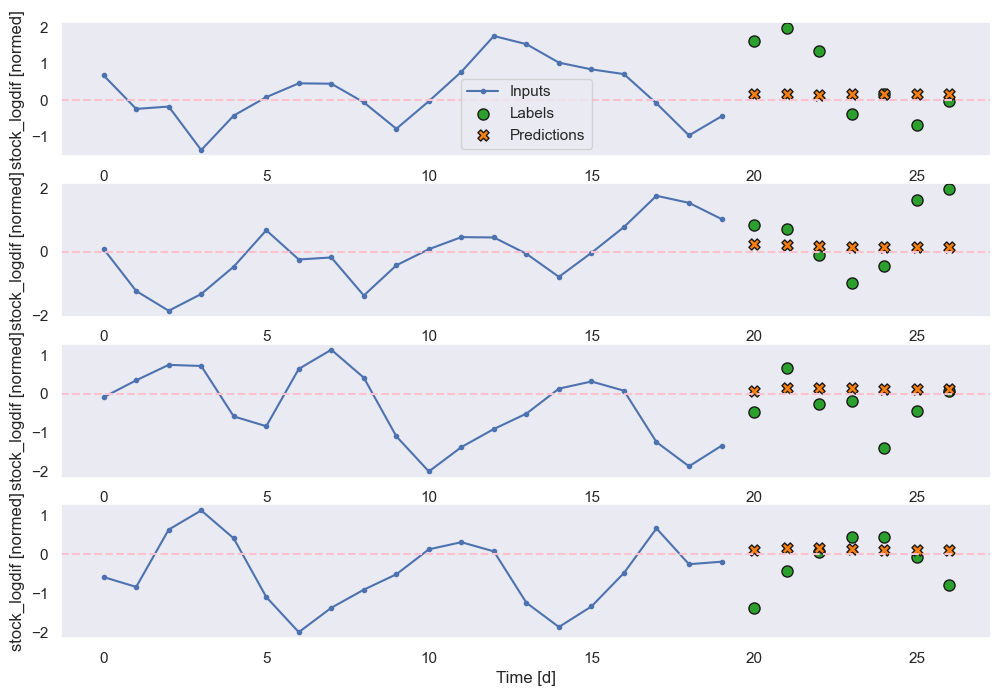

In [43]:
wide_window.plot_test(multi_lstm_model)

In [44]:
best_model_framework =list(multi_performance.keys())[np.argmin(test_mae)]
print(best_model_framework)

Dense


<b> cross validation saving in ml-flow

In [45]:
stock_code_name = run_supermodel_tmp.stock_code

In [46]:
try:
    experiment_id = mlflow.create_experiment(
        f'{stock_code_name}_experiments',
        artifact_location=Path.cwd().joinpath("mlruns").as_uri(),
    )
except:
    print('experiment exists')

Traceback (most recent call last):
  File "C:\Users\Miguel\anaconda3\lib\site-packages\mlflow\store\tracking\file_store.py", line 285, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
  File "C:\Users\Miguel\anaconda3\lib\site-packages\mlflow\store\tracking\file_store.py", line 378, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
  File "C:\Users\Miguel\anaconda3\lib\site-packages\mlflow\store\tracking\file_store.py", line 1082, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
  File "C:\Users\Miguel\anaconda3\lib\site-packages\mlflow\store\tracking\file_store.py", line 1075, in _read_helper
    result = read_yaml(root, file_name)
  File "C:\Users\Miguel\anaconda3\lib\site-packages\mlflow\utils\file_utils.py", line 213, in read_yaml
    raise MissingConfigException("Yaml file '%s' does not exist." % file_path)
mlflow.exceptions.MissingConfigException: Yaml file 'C:\Users\Miguel\vi

In [47]:
client = MlflowClient()
experiments = client.search_experiments()

for exp in experiments:
    exp = dict(exp)
    if exp['name'] == f'{stock_code_name}_experiments':
        exp_id = exp['experiment_id']
        break

Traceback (most recent call last):
  File "C:\Users\Miguel\anaconda3\lib\site-packages\mlflow\store\tracking\file_store.py", line 285, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
  File "C:\Users\Miguel\anaconda3\lib\site-packages\mlflow\store\tracking\file_store.py", line 378, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
  File "C:\Users\Miguel\anaconda3\lib\site-packages\mlflow\store\tracking\file_store.py", line 1082, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
  File "C:\Users\Miguel\anaconda3\lib\site-packages\mlflow\store\tracking\file_store.py", line 1075, in _read_helper
    result = read_yaml(root, file_name)
  File "C:\Users\Miguel\anaconda3\lib\site-packages\mlflow\utils\file_utils.py", line 213, in read_yaml
    raise MissingConfigException("Yaml file '%s' does not exist." % file_path)
mlflow.exceptions.MissingConfigException: Yaml file 'C:\Users\Miguel\vi

In [48]:
def save_model_fun( model, wide_window, final_trial = False ):
    
    registered_model_name = f'{stock_code_name}_models' if final_trial else None
    tags = {"gato": "miguel"}
    desc = "my description"
    
    data_ = wide_window.total_data[-wide_window.input_width:]
    data_ = (data_  - train_mean) / train_std
    data_ = data_.values
    data_ = data_.reshape((1,data_.shape[0],data_.shape[1]))

    signature = infer_signature(data_, model.predict(data_))
        
    try:
        client = MlflowClient()
        client.create_registered_model(registered_model_name,tags, desc)
    except:
        print('folder already exists')
        
    mlflow.tensorflow.log_model(
        model, 
        artifact_path=f"{stock_code_name}-run",
        registered_model_name = registered_model_name,
        signature = signature
    )

    #model.save(best_model_path)

In [49]:
def cross_validation_compiler(model, trial, wide_window, MAX_EPOCHS, patience):
    
    optimizer_name =trial.suggest_categorical('optimizer_name', ['Adam', 'RMSprop'])
    suggested_learning_rate = trial.suggest_float('learning_rate',  1e-6, 1e-2)

    if optimizer_name == 'Adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=suggested_learning_rate)

    else:
        optimizer = tf.keras.optimizers.RMSprop(
            learning_rate=suggested_learning_rate,
            momentum=trial.suggest_float('momentum',  0.1, 0.9),
        )


    model.compile(
        loss=tf.losses.MeanSquaredError(),
        optimizer= optimizer,
        metrics=[tf.metrics.MeanSquaredError()]
    )

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=patience, mode='min')

    history = model.fit(
        wide_window.train,
        epochs=MAX_EPOCHS,
        validation_data=wide_window.val,
        callbacks=[early_stopping],
        verbose = 0
    )

    val_error = model.evaluate(wide_window.val)[1]
    test_error = model.evaluate(wide_window.test)[1]
    
    return optimizer_name, suggested_learning_rate, model, val_error, test_error
    

In [50]:
def commun_log_mlflow(patience,MAX_EPOCHS,optimizer_name,suggested_learning_rate,val_error,test_error,lag_days, input_length):
    
    mlflow.log_param('patience', patience)
    mlflow.log_param('MAX_EPOCHS', MAX_EPOCHS)
    mlflow.log_param('lag_days', lag_days)
    mlflow.log_param('input_length', input_length)
    mlflow.log_param('optimizer_name', optimizer_name)
    mlflow.log_param('learning_rate', suggested_learning_rate)
    mlflow.log_metric("test_MSE", val_error)
    mlflow.log_metric("val_MSE", test_error)
    

In [51]:
def objective_linear(
    trial,
    OUT_STEPS, 
    num_features, 
    wide_window, 
    n_trials,
    patience=2,
    MAX_EPOCHS = 20
):
    
        
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Lambda(lambda x: x[:, -1:, :]))

    num_dense_layers = trial.suggest_int('num_dense_layers', 0, 5) 
    for i in range(num_dense_layers):

        model.add(
            tf.keras.layers.Dense(
                units = trial.suggest_categorical(f'num_units_layers_{i}', [30,70,100,130,150,170,200]),
                kernel_initializer=tf.initializers.zeros(),
                activation = trial.suggest_categorical(f'dense_activation_{i}', ['relu', 'tanh','sigmoid'])
            )
        )
        model.add(
            tf.keras.layers.Dropout(
            rate= trial.suggest_categorical(f'dropout_{i}', [0.0,0.2,0.4,0.6])
            )
        )

    model.add(tf.keras.layers.Dense(OUT_STEPS*num_features,kernel_initializer=tf.initializers.zeros()))
    model.add(tf.keras.layers.Reshape([OUT_STEPS, num_features]))

    global trial_tracker, commun_log_mlflow, cross_validation_compiler, lag_days, input_length, best_error, test_error
    optimizer_name, suggested_learning_rate, model, val_error, test_error = cross_validation_compiler(model, trial, wide_window, MAX_EPOCHS, patience)

    print(f'loggin {trial_tracker} trial, {n_trials}  best error {best_error} test_error {test_error}')
    
    if ( test_error< best_error):
        with mlflow.start_run(run_name = f'{stock_code_name}-run-{today_str}', experiment_id  = exp_id):
            
            commun_log_mlflow(patience,MAX_EPOCHS,optimizer_name,suggested_learning_rate,val_error,test_error,lag_days, input_length)
            mlflow.log_param('model structure', 'Dense')
            mlflow.log_param('num_dense_layers', num_dense_layers)
            best_error = test_error
            save_model_fun(model, wide_window)

    del model
    trial_tracker += 1
        
    return test_error

In [52]:
def objective_conv(
    trial,
    OUT_STEPS, 
    num_features, 
    wide_window, 
    n_trials,
    patience=2,
    MAX_EPOCHS = 20
    ):
    
    model = tf.keras.Sequential()
    
    CONV_WIDTH = trial.suggest_categorical('conv_width', [3,4,5,6,7])
    
    model.add(tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]))
    
    num_conv_layers = trial.suggest_int('num_conv_layers', 1, 1) 
    for i in range(num_conv_layers):
        
        model.add(
            tf.keras.layers.Conv1D(
                filters = trial.suggest_categorical(f'conv_1d_filters_{i}', [150,230,250,270,300]),
                activation = trial.suggest_categorical(f'conv_1d_activation_{i}', ['relu', 'tanh', 'sigmoid']),
                kernel_size=(CONV_WIDTH)
            )
        )
        model.add(
            tf.keras.layers.Dropout(
            rate= trial.suggest_categorical(f'dropout_{i}', [0.0,0.2,0.4,0.6])
            )
        )
          
    num_dense_layers = trial.suggest_int('num_dense_layers', 0, 3) 
    for i in range(num_dense_layers):
        
        model.add(
            tf.keras.layers.Dense(
                units = trial.suggest_categorical(f'num_units_layers_{i}', [30,70,100,130,150,170,200]),
                kernel_initializer=tf.initializers.zeros(),
                activation = trial.suggest_categorical(f'dense_activation_{i}', ['relu', 'tanh','sigmoid'])
            )
        )
        model.add(
            tf.keras.layers.Dropout(
            rate= trial.suggest_categorical(f'dropout_{i}', [0.0,0.2,0.4,0.6])
            )
        )
        
    model.add(tf.keras.layers.Dense(OUT_STEPS*num_features,kernel_initializer=tf.initializers.zeros()))
    model.add(tf.keras.layers.Reshape([OUT_STEPS, num_features]))   
    
    global trial_tracker, commun_log_mlflow, cross_validation_compiler, lag_days, input_length, best_error, test_error
    optimizer_name, suggested_learning_rate, model, val_error, test_error = cross_validation_compiler(model, trial, wide_window, MAX_EPOCHS, patience)
    
    print(f'loggin {trial_tracker} trial, {n_trials} best error {best_error} test_error {test_error}')
    
    if ( test_error< best_error):
        
        with mlflow.start_run(run_name = f'{stock_code_name}-run-{today_str}', experiment_id  = exp_id):
            
            commun_log_mlflow(patience,MAX_EPOCHS,optimizer_name,suggested_learning_rate,val_error,test_error,lag_days, input_length)
            mlflow.log_param('model structure', 'Conv')
            mlflow.log_param('conv_width', CONV_WIDTH)
            mlflow.log_param('num_conv_layers', num_conv_layers)
            mlflow.log_param('num_dense_layers', num_dense_layers)
            best_error = test_error
            save_model_fun(model, wide_window)
            
        del model
        
    trial_tracker += 1
    
    return test_error

In [53]:
def objective_lstm(
    trial,
    OUT_STEPS, 
    num_features, 
    wide_window, 
    n_trials,
    patience=2,
    MAX_EPOCHS = 20
    ):

    model = tf.keras.Sequential()

    num_lstm_layers = trial.suggest_int('num_lstm_layers', 1, 5)
    for i in range(num_lstm_layers):

        sequence_bool = True if num_lstm_layers <= 0 else False if num_lstm_layers-1 == i else True

        model.add(
        tf.keras.layers.LSTM(
            trial.suggest_categorical(f'num_units_layers_{i}', [5,10,15,20,25,30,35,40,45,50,55]), 
            return_sequences=sequence_bool,
            dropout = trial.suggest_float(f'dropoutrate_layers_{i}', 0.2,0.8),
            bias_regularizer= tf.keras.regularizers.L2(trial.suggest_float(f'L2reg_layers_{i}', 1e-6, 1e-2)),
            )
        )

    model.add(tf.keras.layers.Dense(OUT_STEPS*num_features,kernel_initializer=tf.initializers.zeros()))
    model.add(tf.keras.layers.Reshape([OUT_STEPS, num_features]))

    global trial_tracker, commun_log_mlflow, cross_validation_compiler, lag_days, input_length, best_error, test_error
    optimizer_name, suggested_learning_rate, model, val_error, test_error = cross_validation_compiler(model, trial, wide_window, MAX_EPOCHS, patience)
    print(f'loggin {trial_tracker} trial, {n_trials}  best error {best_error} test_error {test_error}')
    
    if ( test_error< best_error):
        
        with mlflow.start_run(run_name = f'{stock_code_name}-run-{today_str}', experiment_id  = exp_id):
            
            commun_log_mlflow(patience,MAX_EPOCHS,optimizer_name,suggested_learning_rate,val_error,test_error,lag_days, input_length)
            mlflow.log_param('model structure', 'LSTM')
            mlflow.log_param('num_lstm_layers', num_lstm_layers)
            best_error = test_error
            save_model_fun(model, wide_window)
            
        del model
        
    trial_tracker += 1
        
    return test_error

In [54]:
class objective_functions():
    ojective_functions =  {
        'Linear': objective_linear,
        'Dense': objective_linear,
        'Conv': objective_conv,
        'LSTM': objective_lstm,
        }

In [55]:
studies_storage = dict()

for type_struc in ['Dense','Conv','LSTM']:  ##,'Dense','Conv',
    trial_tracker = 0
    best_error = best_error_global 
    study = optuna.create_study(
                    direction='minimize',
                    )

    objective = objective_functions.ojective_functions[type_struc] 
    func_objective = lambda trial: objective(trial, OUT_STEPS, num_features, wide_window, run_supermodel_tmp.n_trials_baseline)
    study.optimize(func_objective, n_trials= run_supermodel_tmp.n_trials_baseline)
    
    studies_storage[type_struc] = study

[I 2023-03-08 19:26:56,340] A new study created in memory with name: no-name-459232e3-6fe1-4506-9a0a-c29349782030


3/3 [==============================] - 0s 5ms/step - loss: 1.2303 - mean_squared_error: 1.2303
loggin 0 trial, 10  best error 2.1 test_error 1.2302603721618652
1/1 [==============================] - 0s 316ms/step
folder already exists


INFO:tensorflow:Assets written to: C:\Users\Miguel\AppData\Local\Temp\tmpor5ziqte\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\Miguel\AppData\Local\Temp\tmpor5ziqte\model\data\model\assets
[I 2023-03-08 19:27:15,159] Trial 0 finished with value: 1.2302603721618652 and parameters: {'num_dense_layers': 3, 'num_units_layers_0': 70, 'dense_activation_0': 'tanh', 'dropout_0': 0.4, 'num_units_layers_1': 170, 'dense_activation_1': 'tanh', 'dropout_1': 0.0, 'num_units_layers_2': 200, 'dense_activation_2': 'relu', 'dropout_2': 0.2, 'optimizer_name': 'Adam', 'learning_rate': 0.002777587478385885}. Best is trial 0 with value: 1.2302603721618652.


3/3 [==============================] - 0s 4ms/step - loss: 1.1658 - mean_squared_error: 1.1658
loggin 1 trial, 10  best error 1.2302603721618652 test_error 1.1657642126083374
1/1 [==============================] - 0s 107ms/step
folder already exists


INFO:tensorflow:Assets written to: C:\Users\Miguel\AppData\Local\Temp\tmpr234xdl5\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\Miguel\AppData\Local\Temp\tmpr234xdl5\model\data\model\assets
[I 2023-03-08 19:27:29,199] Trial 1 finished with value: 1.1657642126083374 and parameters: {'num_dense_layers': 0, 'optimizer_name': 'RMSprop', 'learning_rate': 0.005409853932892805, 'momentum': 0.5254179816239447}. Best is trial 1 with value: 1.1657642126083374.


3/3 [==============================] - 0s 4ms/step - loss: 1.1735 - mean_squared_error: 1.1735


[I 2023-03-08 19:27:31,459] Trial 2 finished with value: 1.1734871864318848 and parameters: {'num_dense_layers': 0, 'optimizer_name': 'Adam', 'learning_rate': 0.006402152381936889}. Best is trial 1 with value: 1.1657642126083374.


loggin 2 trial, 10  best error 1.1657642126083374 test_error 1.1734871864318848
3/3 [==============================] - 0s 5ms/step - loss: 1.2303 - mean_squared_error: 1.2303


[I 2023-03-08 19:27:35,597] Trial 3 finished with value: 1.2302533388137817 and parameters: {'num_dense_layers': 5, 'num_units_layers_0': 130, 'dense_activation_0': 'sigmoid', 'dropout_0': 0.6, 'num_units_layers_1': 30, 'dense_activation_1': 'sigmoid', 'dropout_1': 0.2, 'num_units_layers_2': 30, 'dense_activation_2': 'relu', 'dropout_2': 0.2, 'num_units_layers_3': 130, 'dense_activation_3': 'relu', 'dropout_3': 0.4, 'num_units_layers_4': 170, 'dense_activation_4': 'relu', 'dropout_4': 0.2, 'optimizer_name': 'RMSprop', 'learning_rate': 0.00693806801391586, 'momentum': 0.371012876804537}. Best is trial 1 with value: 1.1657642126083374.


loggin 3 trial, 10  best error 1.1657642126083374 test_error 1.2302533388137817
3/3 [==============================] - 0s 4ms/step - loss: 1.2328 - mean_squared_error: 1.2328


[I 2023-03-08 19:27:38,178] Trial 4 finished with value: 1.232765793800354 and parameters: {'num_dense_layers': 3, 'num_units_layers_0': 200, 'dense_activation_0': 'tanh', 'dropout_0': 0.0, 'num_units_layers_1': 200, 'dense_activation_1': 'relu', 'dropout_1': 0.0, 'num_units_layers_2': 70, 'dense_activation_2': 'sigmoid', 'dropout_2': 0.6, 'optimizer_name': 'Adam', 'learning_rate': 0.0013409997374681155}. Best is trial 1 with value: 1.1657642126083374.


loggin 4 trial, 10  best error 1.1657642126083374 test_error 1.232765793800354
3/3 [==============================] - 0s 3ms/step - loss: 1.2301 - mean_squared_error: 1.2301


[I 2023-03-08 19:27:40,315] Trial 5 finished with value: 1.2300944328308105 and parameters: {'num_dense_layers': 1, 'num_units_layers_0': 30, 'dense_activation_0': 'tanh', 'dropout_0': 0.2, 'optimizer_name': 'RMSprop', 'learning_rate': 0.00013787681934635527, 'momentum': 0.37166130139832076}. Best is trial 1 with value: 1.1657642126083374.


loggin 5 trial, 10  best error 1.1657642126083374 test_error 1.2300944328308105
3/3 [==============================] - 0s 3ms/step - loss: 1.2174 - mean_squared_error: 1.2174


[I 2023-03-08 19:27:43,596] Trial 6 finished with value: 1.2174341678619385 and parameters: {'num_dense_layers': 0, 'optimizer_name': 'Adam', 'learning_rate': 0.0006442738945685745}. Best is trial 1 with value: 1.1657642126083374.


loggin 6 trial, 10  best error 1.1657642126083374 test_error 1.2174341678619385
3/3 [==============================] - 0s 5ms/step - loss: 1.3002 - mean_squared_error: 1.3002


[I 2023-03-08 19:27:45,632] Trial 7 finished with value: 1.3002151250839233 and parameters: {'num_dense_layers': 2, 'num_units_layers_0': 200, 'dense_activation_0': 'relu', 'dropout_0': 0.2, 'num_units_layers_1': 170, 'dense_activation_1': 'sigmoid', 'dropout_1': 0.0, 'optimizer_name': 'Adam', 'learning_rate': 0.0051073833606869075}. Best is trial 1 with value: 1.1657642126083374.


loggin 7 trial, 10  best error 1.1657642126083374 test_error 1.3002151250839233
3/3 [==============================] - 0s 4ms/step - loss: 1.1620 - mean_squared_error: 1.1620
loggin 8 trial, 10  best error 1.1657642126083374 test_error 1.1619749069213867
1/1 [==============================] - 0s 109ms/step
folder already exists


INFO:tensorflow:Assets written to: C:\Users\Miguel\AppData\Local\Temp\tmpmr45juaw\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\Miguel\AppData\Local\Temp\tmpmr45juaw\model\data\model\assets
[I 2023-03-08 19:28:00,071] Trial 8 finished with value: 1.1619749069213867 and parameters: {'num_dense_layers': 0, 'optimizer_name': 'Adam', 'learning_rate': 0.005445737280140226}. Best is trial 8 with value: 1.1619749069213867.


3/3 [==============================] - 0s 4ms/step - loss: 1.2462 - mean_squared_error: 1.2462


[I 2023-03-08 19:28:02,692] Trial 9 finished with value: 1.246216893196106 and parameters: {'num_dense_layers': 2, 'num_units_layers_0': 70, 'dense_activation_0': 'relu', 'dropout_0': 0.2, 'num_units_layers_1': 170, 'dense_activation_1': 'sigmoid', 'dropout_1': 0.2, 'optimizer_name': 'Adam', 'learning_rate': 0.009271432850757856}. Best is trial 8 with value: 1.1619749069213867.
[I 2023-03-08 19:28:02,695] A new study created in memory with name: no-name-b80e650a-76e7-462b-a0ec-096c9f8bc530


loggin 9 trial, 10  best error 1.1619749069213867 test_error 1.246216893196106
3/3 [==============================] - 0s 4ms/step - loss: 1.2300 - mean_squared_error: 1.2300
loggin 0 trial, 10 best error 2.1 test_error 1.229976773262024
1/1 [==============================] - 0s 248ms/step
folder already exists


INFO:tensorflow:Assets written to: C:\Users\Miguel\AppData\Local\Temp\tmpixakmsq2\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\Miguel\AppData\Local\Temp\tmpixakmsq2\model\data\model\assets
[I 2023-03-08 19:28:19,579] Trial 0 finished with value: 1.229976773262024 and parameters: {'conv_width': 3, 'num_conv_layers': 1, 'conv_1d_filters_0': 300, 'conv_1d_activation_0': 'tanh', 'dropout_0': 0.4, 'num_dense_layers': 3, 'num_units_layers_0': 170, 'dense_activation_0': 'sigmoid', 'num_units_layers_1': 150, 'dense_activation_1': 'relu', 'dropout_1': 0.0, 'num_units_layers_2': 30, 'dense_activation_2': 'relu', 'dropout_2': 0.0, 'optimizer_name': 'Adam', 'learning_rate': 0.0011399132446121682}. Best is trial 0 with value: 1.229976773262024.


3/3 [==============================] - 0s 4ms/step - loss: 1.1919 - mean_squared_error: 1.1919
loggin 1 trial, 10 best error 1.229976773262024 test_error 1.191919207572937


1/1 [==============================] - 0s 171ms/step
folder already exists


INFO:tensorflow:Assets written to: C:\Users\Miguel\AppData\Local\Temp\tmp40q6mdfu\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\Miguel\AppData\Local\Temp\tmp40q6mdfu\model\data\model\assets
[I 2023-03-08 19:28:35,732] Trial 1 finished with value: 1.191919207572937 and parameters: {'conv_width': 5, 'num_conv_layers': 1, 'conv_1d_filters_0': 150, 'conv_1d_activation_0': 'tanh', 'dropout_0': 0.2, 'num_dense_layers': 1, 'num_units_layers_0': 100, 'dense_activation_0': 'sigmoid', 'optimizer_name': 'Adam', 'learning_rate': 0.003481570505330546}. Best is trial 1 with value: 1.191919207572937.


3/3 [==============================] - 0s 5ms/step - loss: 1.2280 - mean_squared_error: 1.2280


[I 2023-03-08 19:28:38,962] Trial 2 finished with value: 1.2279608249664307 and parameters: {'conv_width': 3, 'num_conv_layers': 1, 'conv_1d_filters_0': 250, 'conv_1d_activation_0': 'relu', 'dropout_0': 0.2, 'num_dense_layers': 1, 'num_units_layers_0': 130, 'dense_activation_0': 'sigmoid', 'optimizer_name': 'RMSprop', 'learning_rate': 0.0054070632360152795, 'momentum': 0.16398076526903643}. Best is trial 1 with value: 1.191919207572937.


loggin 2 trial, 10 best error 1.191919207572937 test_error 1.2279608249664307
3/3 [==============================] - 0s 5ms/step - loss: 1.2300 - mean_squared_error: 1.2300


[I 2023-03-08 19:28:42,291] Trial 3 finished with value: 1.2300316095352173 and parameters: {'conv_width': 3, 'num_conv_layers': 1, 'conv_1d_filters_0': 250, 'conv_1d_activation_0': 'relu', 'dropout_0': 0.4, 'num_dense_layers': 3, 'num_units_layers_0': 170, 'dense_activation_0': 'sigmoid', 'num_units_layers_1': 170, 'dense_activation_1': 'relu', 'dropout_1': 0.6, 'num_units_layers_2': 130, 'dense_activation_2': 'tanh', 'dropout_2': 0.0, 'optimizer_name': 'Adam', 'learning_rate': 0.003767326369224433}. Best is trial 1 with value: 1.191919207572937.


loggin 3 trial, 10 best error 1.191919207572937 test_error 1.2300316095352173
3/3 [==============================] - 0s 5ms/step - loss: 1.2410 - mean_squared_error: 1.2410


[I 2023-03-08 19:28:44,487] Trial 4 finished with value: 1.240990161895752 and parameters: {'conv_width': 6, 'num_conv_layers': 1, 'conv_1d_filters_0': 300, 'conv_1d_activation_0': 'sigmoid', 'dropout_0': 0.6, 'num_dense_layers': 1, 'num_units_layers_0': 170, 'dense_activation_0': 'sigmoid', 'optimizer_name': 'Adam', 'learning_rate': 0.00895283423664091}. Best is trial 1 with value: 1.191919207572937.


loggin 4 trial, 10 best error 1.191919207572937 test_error 1.240990161895752
3/3 [==============================] - 0s 4ms/step - loss: 1.7903 - mean_squared_error: 1.7903


[I 2023-03-08 19:28:46,460] Trial 5 finished with value: 1.790321946144104 and parameters: {'conv_width': 6, 'num_conv_layers': 1, 'conv_1d_filters_0': 270, 'conv_1d_activation_0': 'relu', 'dropout_0': 0.0, 'num_dense_layers': 0, 'optimizer_name': 'RMSprop', 'learning_rate': 0.008222493349842055, 'momentum': 0.5970013986063497}. Best is trial 1 with value: 1.191919207572937.


loggin 5 trial, 10 best error 1.191919207572937 test_error 1.790321946144104
3/3 [==============================] - 0s 4ms/step - loss: 1.2295 - mean_squared_error: 1.2295


[I 2023-03-08 19:28:49,137] Trial 6 finished with value: 1.2295417785644531 and parameters: {'conv_width': 5, 'num_conv_layers': 1, 'conv_1d_filters_0': 270, 'conv_1d_activation_0': 'sigmoid', 'dropout_0': 0.6, 'num_dense_layers': 2, 'num_units_layers_0': 170, 'dense_activation_0': 'sigmoid', 'num_units_layers_1': 200, 'dense_activation_1': 'sigmoid', 'dropout_1': 0.6, 'optimizer_name': 'RMSprop', 'learning_rate': 0.0014994129742140058, 'momentum': 0.8823211492450116}. Best is trial 1 with value: 1.191919207572937.


loggin 6 trial, 10 best error 1.191919207572937 test_error 1.2295417785644531
3/3 [==============================] - 0s 5ms/step - loss: 1.2307 - mean_squared_error: 1.2307
loggin 7 trial, 10 best error 1.191919207572937 test_error 1.2307155132293701


[I 2023-03-08 19:28:51,528] Trial 7 finished with value: 1.2307155132293701 and parameters: {'conv_width': 6, 'num_conv_layers': 1, 'conv_1d_filters_0': 300, 'conv_1d_activation_0': 'sigmoid', 'dropout_0': 0.6, 'num_dense_layers': 1, 'num_units_layers_0': 130, 'dense_activation_0': 'sigmoid', 'optimizer_name': 'RMSprop', 'learning_rate': 0.006552234970639386, 'momentum': 0.7256216784007549}. Best is trial 1 with value: 1.191919207572937.


3/3 [==============================] - 0s 5ms/step - loss: 1.2347 - mean_squared_error: 1.2347


[I 2023-03-08 19:28:54,155] Trial 8 finished with value: 1.2346999645233154 and parameters: {'conv_width': 4, 'num_conv_layers': 1, 'conv_1d_filters_0': 250, 'conv_1d_activation_0': 'tanh', 'dropout_0': 0.4, 'num_dense_layers': 1, 'num_units_layers_0': 130, 'dense_activation_0': 'sigmoid', 'optimizer_name': 'RMSprop', 'learning_rate': 0.0009497975384724519, 'momentum': 0.17880739124037837}. Best is trial 1 with value: 1.191919207572937.


loggin 8 trial, 10 best error 1.191919207572937 test_error 1.2346999645233154
3/3 [==============================] - 0s 4ms/step - loss: 1.2446 - mean_squared_error: 1.2446


[I 2023-03-08 19:28:57,223] Trial 9 finished with value: 1.2446147203445435 and parameters: {'conv_width': 4, 'num_conv_layers': 1, 'conv_1d_filters_0': 230, 'conv_1d_activation_0': 'tanh', 'dropout_0': 0.0, 'num_dense_layers': 2, 'num_units_layers_0': 150, 'dense_activation_0': 'relu', 'num_units_layers_1': 130, 'dense_activation_1': 'sigmoid', 'dropout_1': 0.0, 'optimizer_name': 'Adam', 'learning_rate': 0.008028787058449116}. Best is trial 1 with value: 1.191919207572937.
[I 2023-03-08 19:28:57,224] A new study created in memory with name: no-name-595c9ac1-f985-4e72-99e5-40e595aead3c


loggin 9 trial, 10 best error 1.191919207572937 test_error 1.2446147203445435
3/3 [==============================] - 0s 10ms/step - loss: 1.4392 - mean_squared_error: 1.2450
loggin 0 trial, 10  best error 2.1 test_error 1.245002031326294


1/1 [==============================] - 2s 2s/step
folder already exists


INFO:tensorflow:Assets written to: C:\Users\Miguel\AppData\Local\Temp\tmp4n_ujpvv\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\Miguel\AppData\Local\Temp\tmp4n_ujpvv\model\data\model\assets
[I 2023-03-08 19:30:02,060] Trial 0 finished with value: 1.245002031326294 and parameters: {'num_lstm_layers': 4, 'num_units_layers_0': 30, 'dropoutrate_layers_0': 0.7790552514625084, 'L2reg_layers_0': 0.0016718216232485734, 'num_units_layers_1': 15, 'dropoutrate_layers_1': 0.46215101893170063, 'L2reg_layers_1': 0.0036047986723232845, 'num_units_layers_2': 30, 'dropoutrate_layers_2': 0.5784375660805017, 'L2reg_layers_2': 0.00913146491286734, 'num_units_layers_3': 15, 'dropoutrate_layers_3': 0.7357215782153086, 'L2reg_layers_3': 0.007199990387118618, 'optimizer_name': 'Adam', 'learning_rate': 0.004756427808438562}. Best is trial 0 with value: 1.245002031326294.


3/3 [==============================] - 0s 9ms/step - loss: 1.2562 - mean_squared_error: 1.2491


[I 2023-03-08 19:30:09,942] Trial 1 finished with value: 1.2490886449813843 and parameters: {'num_lstm_layers': 2, 'num_units_layers_0': 20, 'dropoutrate_layers_0': 0.2121839002972048, 'L2reg_layers_0': 0.00625887211208515, 'num_units_layers_1': 50, 'dropoutrate_layers_1': 0.6250735411966343, 'L2reg_layers_1': 0.007273595832957841, 'optimizer_name': 'RMSprop', 'learning_rate': 0.003975771364966305, 'momentum': 0.7892662800024507}. Best is trial 0 with value: 1.245002031326294.


loggin 1 trial, 10  best error 1.245002031326294 test_error 1.2490886449813843
3/3 [==============================] - 0s 8ms/step - loss: 1.5254 - mean_squared_error: 1.2251
loggin 2 trial, 10  best error 1.245002031326294 test_error 1.2250592708587646
1/1 [==============================] - 1s 810ms/step
folder already exists


INFO:tensorflow:Assets written to: C:\Users\Miguel\AppData\Local\Temp\tmpi_vkl017\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\Miguel\AppData\Local\Temp\tmpi_vkl017\model\data\model\assets
[I 2023-03-08 19:30:47,641] Trial 2 finished with value: 1.2250592708587646 and parameters: {'num_lstm_layers': 2, 'num_units_layers_0': 5, 'dropoutrate_layers_0': 0.6894966470703059, 'L2reg_layers_0': 0.004653369806039628, 'num_units_layers_1': 45, 'dropoutrate_layers_1': 0.5966062350455761, 'L2reg_layers_1': 0.0075746071479847405, 'optimizer_name': 'Adam', 'learning_rate': 0.0011123349551937542}. Best is trial 2 with value: 1.2250592708587646.


3/3 [==============================] - 0s 18ms/step - loss: 1.2839 - mean_squared_error: 1.2495


[I 2023-03-08 19:31:11,184] Trial 3 finished with value: 1.2495262622833252 and parameters: {'num_lstm_layers': 5, 'num_units_layers_0': 50, 'dropoutrate_layers_0': 0.6400315430857266, 'L2reg_layers_0': 0.002067018322443158, 'num_units_layers_1': 20, 'dropoutrate_layers_1': 0.40761775107679943, 'L2reg_layers_1': 0.009503684482462818, 'num_units_layers_2': 50, 'dropoutrate_layers_2': 0.5967257532998916, 'L2reg_layers_2': 0.004721641472163171, 'num_units_layers_3': 10, 'dropoutrate_layers_3': 0.3356517314787525, 'L2reg_layers_3': 0.002718426496093815, 'num_units_layers_4': 55, 'dropoutrate_layers_4': 0.6684248162602071, 'L2reg_layers_4': 0.005781515183949531, 'optimizer_name': 'RMSprop', 'learning_rate': 0.004827499411724907, 'momentum': 0.1896731646767921}. Best is trial 2 with value: 1.2250592708587646.


loggin 3 trial, 10  best error 1.2250592708587646 test_error 1.2495262622833252
3/3 [==============================] - 0s 12ms/step - loss: 1.6091 - mean_squared_error: 1.2174
loggin 4 trial, 10  best error 1.2250592708587646 test_error 1.2174400091171265
1/1 [==============================] - 1s 1s/step
folder already exists


INFO:tensorflow:Assets written to: C:\Users\Miguel\AppData\Local\Temp\tmpi4po_66c\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\Miguel\AppData\Local\Temp\tmpi4po_66c\model\data\model\assets
[I 2023-03-08 19:31:56,851] Trial 4 finished with value: 1.2174400091171265 and parameters: {'num_lstm_layers': 3, 'num_units_layers_0': 50, 'dropoutrate_layers_0': 0.5569126301908045, 'L2reg_layers_0': 0.003416828770263732, 'num_units_layers_1': 30, 'dropoutrate_layers_1': 0.38728656989580584, 'L2reg_layers_1': 0.006293322303719561, 'num_units_layers_2': 35, 'dropoutrate_layers_2': 0.48735685086896785, 'L2reg_layers_2': 0.0057392285612795834, 'optimizer_name': 'Adam', 'learning_rate': 0.004690225693608066}. Best is trial 4 with value: 1.2174400091171265.


3/3 [==============================] - 0s 8ms/step - loss: 1.2500 - mean_squared_error: 1.2210


[I 2023-03-08 19:32:06,606] Trial 5 finished with value: 1.2209608554840088 and parameters: {'num_lstm_layers': 2, 'num_units_layers_0': 20, 'dropoutrate_layers_0': 0.5843141206729895, 'L2reg_layers_0': 0.006145179867735587, 'num_units_layers_1': 35, 'dropoutrate_layers_1': 0.7262461417350408, 'L2reg_layers_1': 0.00933327107897009, 'optimizer_name': 'Adam', 'learning_rate': 0.009227065126291853}. Best is trial 4 with value: 1.2174400091171265.


loggin 5 trial, 10  best error 1.2174400091171265 test_error 1.2209608554840088
3/3 [==============================] - 0s 15ms/step - loss: 1.2372 - mean_squared_error: 1.2323


[I 2023-03-08 19:32:22,204] Trial 6 finished with value: 1.2323111295700073 and parameters: {'num_lstm_layers': 4, 'num_units_layers_0': 35, 'dropoutrate_layers_0': 0.5034503725857477, 'L2reg_layers_0': 0.009648232713407867, 'num_units_layers_1': 10, 'dropoutrate_layers_1': 0.6779717046506698, 'L2reg_layers_1': 0.0020497045514770275, 'num_units_layers_2': 55, 'dropoutrate_layers_2': 0.6222223993041085, 'L2reg_layers_2': 0.0011572917663909023, 'num_units_layers_3': 15, 'dropoutrate_layers_3': 0.6888378324911228, 'L2reg_layers_3': 0.00029219452426200784, 'optimizer_name': 'RMSprop', 'learning_rate': 0.007765161736339355, 'momentum': 0.8768126224072665}. Best is trial 4 with value: 1.2174400091171265.


loggin 6 trial, 10  best error 1.2174400091171265 test_error 1.2323111295700073
3/3 [==============================] - 0s 10ms/step - loss: 1.2896 - mean_squared_error: 1.2199


[I 2023-03-08 19:32:30,640] Trial 7 finished with value: 1.219869613647461 and parameters: {'num_lstm_layers': 2, 'num_units_layers_0': 50, 'dropoutrate_layers_0': 0.5678816612215796, 'L2reg_layers_0': 0.0006008457705133033, 'num_units_layers_1': 40, 'dropoutrate_layers_1': 0.755813579941701, 'L2reg_layers_1': 0.001966251225902989, 'optimizer_name': 'Adam', 'learning_rate': 0.006250288679208736}. Best is trial 4 with value: 1.2174400091171265.


loggin 7 trial, 10  best error 1.2174400091171265 test_error 1.219869613647461
3/3 [==============================] - 0s 7ms/step - loss: 1.2196 - mean_squared_error: 1.2066
loggin 8 trial, 10  best error 1.2174400091171265 test_error 1.2065820693969727
1/1 [==============================] - 1s 531ms/step
folder already exists


INFO:tensorflow:Assets written to: C:\Users\Miguel\AppData\Local\Temp\tmphmwf170a\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\Miguel\AppData\Local\Temp\tmphmwf170a\model\data\model\assets
[I 2023-03-08 19:32:54,398] Trial 8 finished with value: 1.2065820693969727 and parameters: {'num_lstm_layers': 1, 'num_units_layers_0': 15, 'dropoutrate_layers_0': 0.4246802962084924, 'L2reg_layers_0': 0.0016019404596260068, 'optimizer_name': 'RMSprop', 'learning_rate': 0.006853043316491068, 'momentum': 0.18778663154499053}. Best is trial 8 with value: 1.2065820693969727.


3/3 [==============================] - 0s 14ms/step - loss: 1.2156 - mean_squared_error: 1.2089


[I 2023-03-08 19:33:10,397] Trial 9 finished with value: 1.2089016437530518 and parameters: {'num_lstm_layers': 4, 'num_units_layers_0': 35, 'dropoutrate_layers_0': 0.44167355978054507, 'L2reg_layers_0': 0.0026323996029435246, 'num_units_layers_1': 15, 'dropoutrate_layers_1': 0.7633085863826246, 'L2reg_layers_1': 0.0010934311395674973, 'num_units_layers_2': 20, 'dropoutrate_layers_2': 0.3555370677056317, 'L2reg_layers_2': 0.006238942741747341, 'num_units_layers_3': 55, 'dropoutrate_layers_3': 0.22892416681029396, 'L2reg_layers_3': 0.00045279969051640245, 'optimizer_name': 'RMSprop', 'learning_rate': 0.008662427677141843, 'momentum': 0.8102776503086634}. Best is trial 8 with value: 1.2065820693969727.


loggin 9 trial, 10  best error 1.2065820693969727 test_error 1.2089016437530518


<b> best structure tunning

In [56]:
run = MlflowClient().search_runs(
    experiment_ids=[exp_id],
    filter_string = f"tags.mlflow.runName LIKE '%{stock_code_name}-run-{today_str}%'",
    order_by = ["metrics.test_MSE ASC"],
    max_results=1,
)[0]

In [57]:
best_structure = run.data.params['model structure']
best_error_study = run.data.metrics['test_MSE']
best_study = studies_storage[best_structure]  ## best_structure

In [58]:
best_error_study, best_study.best_params, best_structure

(1.7397717237472534,
 {'conv_width': 5,
  'num_conv_layers': 1,
  'conv_1d_filters_0': 150,
  'conv_1d_activation_0': 'tanh',
  'dropout_0': 0.2,
  'num_dense_layers': 1,
  'num_units_layers_0': 100,
  'dense_activation_0': 'sigmoid',
  'optimizer_name': 'Adam',
  'learning_rate': 0.003481570505330546},
 'Conv')

In [59]:
best_error_study

1.7397717237472534

In [60]:
trial_tracker = 0
best_error = best_error_study
second_study = optuna.create_study(
                direction='minimize',
                )

second_study.add_trials(best_study.trials)

objective = objective_functions.ojective_functions[best_structure] ###  best_structure 
func_objective = lambda trial: objective(trial, OUT_STEPS, num_features, wide_window, best_error_study,run_supermodel_tmp.n_trials_deepdive)
second_study.optimize(func_objective, n_trials= run_supermodel_tmp.n_trials_deepdive)

[I 2023-03-08 19:33:11,090] A new study created in memory with name: no-name-f287589f-a7d0-4d3a-968e-13005dad1fad


3/3 [==============================] - 0s 4ms/step - loss: 1.3984 - mean_squared_error: 1.3984
loggin 0 trial, 1.7397717237472534 best error 1.7397717237472534 test_error 1.3984014987945557
1/1 [==============================] - 0s 132ms/step
folder already exists


INFO:tensorflow:Assets written to: C:\Users\Miguel\AppData\Local\Temp\tmpjr97ku8h\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\Miguel\AppData\Local\Temp\tmpjr97ku8h\model\data\model\assets
[I 2023-03-08 19:33:28,950] Trial 10 finished with value: 1.3984014987945557 and parameters: {'conv_width': 5, 'num_conv_layers': 1, 'conv_1d_filters_0': 150, 'conv_1d_activation_0': 'tanh', 'dropout_0': 0.2, 'num_dense_layers': 0, 'optimizer_name': 'Adam', 'learning_rate': 0.0032055360285168943}. Best is trial 1 with value: 1.191919207572937.


3/3 [==============================] - 0s 3ms/step - loss: 1.2299 - mean_squared_error: 1.2299
loggin 1 trial, 1.7397717237472534 best error 1.3984014987945557 test_error 1.2299331426620483
1/1 [==============================] - 0s 124ms/step
folder already exists


INFO:tensorflow:Assets written to: C:\Users\Miguel\AppData\Local\Temp\tmpyawbtumg\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\Miguel\AppData\Local\Temp\tmpyawbtumg\model\data\model\assets
[I 2023-03-08 19:33:46,222] Trial 11 finished with value: 1.2299331426620483 and parameters: {'conv_width': 7, 'num_conv_layers': 1, 'conv_1d_filters_0': 150, 'conv_1d_activation_0': 'relu', 'dropout_0': 0.2, 'num_dense_layers': 1, 'num_units_layers_0': 100, 'dense_activation_0': 'tanh', 'optimizer_name': 'RMSprop', 'learning_rate': 0.0056672504808212235, 'momentum': 0.11169862479654497}. Best is trial 1 with value: 1.191919207572937.


3/3 [==============================] - 0s 4ms/step - loss: 1.6843 - mean_squared_error: 1.6843
loggin 2 trial, 1.7397717237472534 best error 1.2299331426620483 test_error 1.6842741966247559


[I 2023-03-08 19:33:51,022] Trial 12 finished with value: 1.6842741966247559 and parameters: {'conv_width': 5, 'num_conv_layers': 1, 'conv_1d_filters_0': 250, 'conv_1d_activation_0': 'relu', 'dropout_0': 0.2, 'num_dense_layers': 0, 'optimizer_name': 'Adam', 'learning_rate': 0.004672631278516684}. Best is trial 1 with value: 1.191919207572937.


3/3 [==============================] - 0s 5ms/step - loss: 1.2302 - mean_squared_error: 1.2302


[I 2023-03-08 19:33:56,381] Trial 13 finished with value: 1.230167031288147 and parameters: {'conv_width': 3, 'num_conv_layers': 1, 'conv_1d_filters_0': 150, 'conv_1d_activation_0': 'tanh', 'dropout_0': 0.2, 'num_dense_layers': 2, 'num_units_layers_0': 30, 'dense_activation_0': 'relu', 'num_units_layers_1': 70, 'dense_activation_1': 'tanh', 'dropout_1': 0.4, 'optimizer_name': 'RMSprop', 'learning_rate': 0.003096500105433393, 'momentum': 0.3474996268544503}. Best is trial 1 with value: 1.191919207572937.


loggin 3 trial, 1.7397717237472534 best error 1.2299331426620483 test_error 1.230167031288147
3/3 [==============================] - 0s 4ms/step - loss: 1.2302 - mean_squared_error: 1.2302


[I 2023-03-08 19:34:02,684] Trial 14 finished with value: 1.2301515340805054 and parameters: {'conv_width': 7, 'num_conv_layers': 1, 'conv_1d_filters_0': 230, 'conv_1d_activation_0': 'relu', 'dropout_0': 0.2, 'num_dense_layers': 1, 'num_units_layers_0': 100, 'dense_activation_0': 'tanh', 'optimizer_name': 'RMSprop', 'learning_rate': 0.006489495312705812, 'momentum': 0.37111020377967796}. Best is trial 1 with value: 1.191919207572937.


loggin 4 trial, 1.7397717237472534 best error 1.2299331426620483 test_error 1.2301515340805054
3/3 [==============================] - 0s 5ms/step - loss: 1.2300 - mean_squared_error: 1.2300


[I 2023-03-08 19:34:08,387] Trial 15 finished with value: 1.2300374507904053 and parameters: {'conv_width': 5, 'num_conv_layers': 1, 'conv_1d_filters_0': 250, 'conv_1d_activation_0': 'tanh', 'dropout_0': 0.2, 'num_dense_layers': 2, 'num_units_layers_0': 200, 'dense_activation_0': 'sigmoid', 'num_units_layers_1': 30, 'dense_activation_1': 'tanh', 'dropout_1': 0.2, 'optimizer_name': 'Adam', 'learning_rate': 0.004825500138058323}. Best is trial 1 with value: 1.191919207572937.


loggin 5 trial, 1.7397717237472534 best error 1.2299331426620483 test_error 1.2300374507904053
3/3 [==============================] - 0s 5ms/step - loss: 1.4467 - mean_squared_error: 1.4467


[I 2023-03-08 19:34:15,137] Trial 16 finished with value: 1.4467166662216187 and parameters: {'conv_width': 3, 'num_conv_layers': 1, 'conv_1d_filters_0': 150, 'conv_1d_activation_0': 'relu', 'dropout_0': 0.2, 'num_dense_layers': 0, 'optimizer_name': 'RMSprop', 'learning_rate': 0.0023577095946760228, 'momentum': 0.27346556256211396}. Best is trial 1 with value: 1.191919207572937.


loggin 6 trial, 1.7397717237472534 best error 1.2299331426620483 test_error 1.4467166662216187
3/3 [==============================] - 0s 6ms/step - loss: 1.3637 - mean_squared_error: 1.3637


[I 2023-03-08 19:34:20,409] Trial 17 finished with value: 1.3636841773986816 and parameters: {'conv_width': 5, 'num_conv_layers': 1, 'conv_1d_filters_0': 150, 'conv_1d_activation_0': 'tanh', 'dropout_0': 0.2, 'num_dense_layers': 1, 'num_units_layers_0': 70, 'dense_activation_0': 'sigmoid', 'optimizer_name': 'Adam', 'learning_rate': 0.009925027866581957}. Best is trial 1 with value: 1.191919207572937.


loggin 7 trial, 1.7397717237472534 best error 1.2299331426620483 test_error 1.3636841773986816
3/3 [==============================] - 0s 4ms/step - loss: 1.2299 - mean_squared_error: 1.2299


[I 2023-03-08 19:34:25,649] Trial 18 finished with value: 1.2299376726150513 and parameters: {'conv_width': 3, 'num_conv_layers': 1, 'conv_1d_filters_0': 250, 'conv_1d_activation_0': 'relu', 'dropout_0': 0.0, 'num_dense_layers': 2, 'num_units_layers_0': 100, 'dense_activation_0': 'tanh', 'num_units_layers_1': 100, 'dense_activation_1': 'tanh', 'dropout_1': 0.4, 'optimizer_name': 'Adam', 'learning_rate': 0.004079252581134222}. Best is trial 1 with value: 1.191919207572937.


loggin 8 trial, 1.7397717237472534 best error 1.2299331426620483 test_error 1.2299376726150513
3/3 [==============================] - 0s 4ms/step - loss: 1.2202 - mean_squared_error: 1.2202
loggin 9 trial, 1.7397717237472534 best error 1.2299331426620483 test_error 1.2202153205871582
1/1 [==============================] - 0s 137ms/step
folder already exists


INFO:tensorflow:Assets written to: C:\Users\Miguel\AppData\Local\Temp\tmpxwrw1w72\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\Miguel\AppData\Local\Temp\tmpxwrw1w72\model\data\model\assets
[I 2023-03-08 19:34:42,498] Trial 19 finished with value: 1.2202153205871582 and parameters: {'conv_width': 4, 'num_conv_layers': 1, 'conv_1d_filters_0': 270, 'conv_1d_activation_0': 'sigmoid', 'dropout_0': 0.2, 'num_dense_layers': 0, 'optimizer_name': 'RMSprop', 'learning_rate': 0.0003618220511248998, 'momentum': 0.4345959492710423}. Best is trial 1 with value: 1.191919207572937.


3/3 [==============================] - 0s 4ms/step - loss: 1.2203 - mean_squared_error: 1.2203
loggin 10 trial, 1.7397717237472534 best error 1.2202153205871582 test_error 1.2202503681182861

[I 2023-03-08 19:34:48,137] Trial 20 finished with value: 1.2202503681182861 and parameters: {'conv_width': 4, 'num_conv_layers': 1, 'conv_1d_filters_0': 270, 'conv_1d_activation_0': 'sigmoid', 'dropout_0': 0.2, 'num_dense_layers': 0, 'optimizer_name': 'Adam', 'learning_rate': 0.000426678402488168}. Best is trial 1 with value: 1.191919207572937.



3/3 [==============================] - 0s 4ms/step - loss: 1.2250 - mean_squared_error: 1.2250


[I 2023-03-08 19:34:52,616] Trial 21 finished with value: 1.224987506866455 and parameters: {'conv_width': 4, 'num_conv_layers': 1, 'conv_1d_filters_0': 270, 'conv_1d_activation_0': 'sigmoid', 'dropout_0': 0.2, 'num_dense_layers': 0, 'optimizer_name': 'Adam', 'learning_rate': 9.295835276495676e-05}. Best is trial 1 with value: 1.191919207572937.


loggin 11 trial, 1.7397717237472534 best error 1.2202153205871582 test_error 1.224987506866455
3/3 [==============================] - 0s 4ms/step - loss: 1.2260 - mean_squared_error: 1.2260


[I 2023-03-08 19:34:56,930] Trial 22 finished with value: 1.2259594202041626 and parameters: {'conv_width': 4, 'num_conv_layers': 1, 'conv_1d_filters_0': 270, 'conv_1d_activation_0': 'sigmoid', 'dropout_0': 0.2, 'num_dense_layers': 0, 'optimizer_name': 'Adam', 'learning_rate': 7.592817785943053e-05}. Best is trial 1 with value: 1.191919207572937.


loggin 12 trial, 1.7397717237472534 best error 1.2202153205871582 test_error 1.2259594202041626
3/3 [==============================] - 0s 5ms/step - loss: 1.1738 - mean_squared_error: 1.1738
loggin 13 trial, 1.7397717237472534 best error 1.2202153205871582 test_error 1.1737993955612183
1/1 [==============================] - 0s 124ms/step
folder already exists


INFO:tensorflow:Assets written to: C:\Users\Miguel\AppData\Local\Temp\tmpuiim04bb\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\Miguel\AppData\Local\Temp\tmpuiim04bb\model\data\model\assets
[I 2023-03-08 19:35:14,462] Trial 23 finished with value: 1.1737993955612183 and parameters: {'conv_width': 4, 'num_conv_layers': 1, 'conv_1d_filters_0': 270, 'conv_1d_activation_0': 'sigmoid', 'dropout_0': 0.2, 'num_dense_layers': 0, 'optimizer_name': 'Adam', 'learning_rate': 0.0021816869249064747}. Best is trial 23 with value: 1.1737993955612183.


3/3 [==============================] - 0s 4ms/step - loss: 1.1782 - mean_squared_error: 1.1782


[I 2023-03-08 19:35:21,129] Trial 24 finished with value: 1.1782152652740479 and parameters: {'conv_width': 4, 'num_conv_layers': 1, 'conv_1d_filters_0': 270, 'conv_1d_activation_0': 'sigmoid', 'dropout_0': 0.2, 'num_dense_layers': 0, 'optimizer_name': 'Adam', 'learning_rate': 0.0020344407197100795}. Best is trial 23 with value: 1.1737993955612183.


loggin 14 trial, 1.7397717237472534 best error 1.1737993955612183 test_error 1.1782152652740479
3/3 [==============================] - 0s 5ms/step - loss: 1.1969 - mean_squared_error: 1.1969


[I 2023-03-08 19:35:25,958] Trial 25 finished with value: 1.1969317197799683 and parameters: {'conv_width': 4, 'num_conv_layers': 1, 'conv_1d_filters_0': 270, 'conv_1d_activation_0': 'sigmoid', 'dropout_0': 0.2, 'num_dense_layers': 0, 'optimizer_name': 'Adam', 'learning_rate': 0.0019685537768935235}. Best is trial 23 with value: 1.1737993955612183.


loggin 15 trial, 1.7397717237472534 best error 1.1737993955612183 test_error 1.1969317197799683
3/3 [==============================] - 0s 5ms/step - loss: 1.2300 - mean_squared_error: 1.2300


[I 2023-03-08 19:35:32,201] Trial 26 finished with value: 1.2300188541412354 and parameters: {'conv_width': 4, 'num_conv_layers': 1, 'conv_1d_filters_0': 270, 'conv_1d_activation_0': 'sigmoid', 'dropout_0': 0.0, 'num_dense_layers': 1, 'num_units_layers_0': 200, 'dense_activation_0': 'relu', 'optimizer_name': 'Adam', 'learning_rate': 0.002452771231060501}. Best is trial 23 with value: 1.1737993955612183.


loggin 16 trial, 1.7397717237472534 best error 1.1737993955612183 test_error 1.2300188541412354
3/3 [==============================] - 0s 5ms/step - loss: 1.2757 - mean_squared_error: 1.2757


[I 2023-03-08 19:35:37,745] Trial 27 finished with value: 1.2757267951965332 and parameters: {'conv_width': 7, 'num_conv_layers': 1, 'conv_1d_filters_0': 230, 'conv_1d_activation_0': 'sigmoid', 'dropout_0': 0.6, 'num_dense_layers': 0, 'optimizer_name': 'Adam', 'learning_rate': 0.0017708012140748128}. Best is trial 23 with value: 1.1737993955612183.


loggin 17 trial, 1.7397717237472534 best error 1.1737993955612183 test_error 1.2757267951965332
3/3 [==============================] - 0s 4ms/step - loss: 1.2214 - mean_squared_error: 1.2214


[I 2023-03-08 19:35:41,783] Trial 28 finished with value: 1.2213881015777588 and parameters: {'conv_width': 5, 'num_conv_layers': 1, 'conv_1d_filters_0': 150, 'conv_1d_activation_0': 'sigmoid', 'dropout_0': 0.4, 'num_dense_layers': 0, 'optimizer_name': 'Adam', 'learning_rate': 0.002771764548191465}. Best is trial 23 with value: 1.1737993955612183.


loggin 18 trial, 1.7397717237472534 best error 1.1737993955612183 test_error 1.2213881015777588
3/3 [==============================] - 0s 4ms/step - loss: 1.2302 - mean_squared_error: 1.2302


[I 2023-03-08 19:35:47,200] Trial 29 finished with value: 1.2302111387252808 and parameters: {'conv_width': 4, 'num_conv_layers': 1, 'conv_1d_filters_0': 300, 'conv_1d_activation_0': 'tanh', 'dropout_0': 0.4, 'num_dense_layers': 1, 'num_units_layers_0': 150, 'dense_activation_0': 'relu', 'optimizer_name': 'Adam', 'learning_rate': 0.0012993740757047878}. Best is trial 23 with value: 1.1737993955612183.


loggin 19 trial, 1.7397717237472534 best error 1.1737993955612183 test_error 1.2302111387252808
3/3 [==============================] - 0s 4ms/step - loss: 1.2317 - mean_squared_error: 1.2317


[I 2023-03-08 19:35:55,292] Trial 30 finished with value: 1.231697916984558 and parameters: {'conv_width': 4, 'num_conv_layers': 1, 'conv_1d_filters_0': 270, 'conv_1d_activation_0': 'tanh', 'dropout_0': 0.2, 'num_dense_layers': 3, 'num_units_layers_0': 70, 'dense_activation_0': 'tanh', 'num_units_layers_1': 100, 'dense_activation_1': 'relu', 'dropout_1': 0.2, 'num_units_layers_2': 150, 'dense_activation_2': 'sigmoid', 'dropout_2': 0.4, 'optimizer_name': 'Adam', 'learning_rate': 0.0035428424766166234}. Best is trial 23 with value: 1.1737993955612183.


loggin 20 trial, 1.7397717237472534 best error 1.1737993955612183 test_error 1.231697916984558
3/3 [==============================] - 0s 3ms/step - loss: 1.1788 - mean_squared_error: 1.1788


[I 2023-03-08 19:35:59,713] Trial 31 finished with value: 1.1787787675857544 and parameters: {'conv_width': 4, 'num_conv_layers': 1, 'conv_1d_filters_0': 270, 'conv_1d_activation_0': 'sigmoid', 'dropout_0': 0.2, 'num_dense_layers': 0, 'optimizer_name': 'Adam', 'learning_rate': 0.002086431815842451}. Best is trial 23 with value: 1.1737993955612183.


loggin 21 trial, 1.7397717237472534 best error 1.1737993955612183 test_error 1.1787787675857544
3/3 [==============================] - 0s 4ms/step - loss: 1.1954 - mean_squared_error: 1.1954
loggin 22 trial, 1.7397717237472534 best error 1.1737993955612183 test_error 1.1954174041748047


[I 2023-03-08 19:36:04,664] Trial 32 finished with value: 1.1954174041748047 and parameters: {'conv_width': 4, 'num_conv_layers': 1, 'conv_1d_filters_0': 270, 'conv_1d_activation_0': 'sigmoid', 'dropout_0': 0.2, 'num_dense_layers': 0, 'optimizer_name': 'Adam', 'learning_rate': 0.002264010285056629}. Best is trial 23 with value: 1.1737993955612183.


3/3 [==============================] - 0s 4ms/step - loss: 1.1813 - mean_squared_error: 1.1813


[I 2023-03-08 19:36:10,181] Trial 33 finished with value: 1.1813138723373413 and parameters: {'conv_width': 4, 'num_conv_layers': 1, 'conv_1d_filters_0': 270, 'conv_1d_activation_0': 'sigmoid', 'dropout_0': 0.2, 'num_dense_layers': 0, 'optimizer_name': 'Adam', 'learning_rate': 0.001055777506903564}. Best is trial 23 with value: 1.1737993955612183.


loggin 23 trial, 1.7397717237472534 best error 1.1737993955612183 test_error 1.1813138723373413
3/3 [==============================] - 0s 4ms/step - loss: 1.1858 - mean_squared_error: 1.1858


[I 2023-03-08 19:36:14,704] Trial 34 finished with value: 1.185807704925537 and parameters: {'conv_width': 4, 'num_conv_layers': 1, 'conv_1d_filters_0': 270, 'conv_1d_activation_0': 'sigmoid', 'dropout_0': 0.2, 'num_dense_layers': 0, 'optimizer_name': 'Adam', 'learning_rate': 0.001026889629858247}. Best is trial 23 with value: 1.1737993955612183.


loggin 24 trial, 1.7397717237472534 best error 1.1737993955612183 test_error 1.185807704925537
3/3 [==============================] - 0s 4ms/step - loss: 1.1728 - mean_squared_error: 1.1728
loggin 25 trial, 1.7397717237472534 best error 1.1737993955612183 test_error 1.1727749109268188
1/1 [==============================] - 0s 127ms/step
folder already exists


INFO:tensorflow:Assets written to: C:\Users\Miguel\AppData\Local\Temp\tmp_d59n7gb\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\Miguel\AppData\Local\Temp\tmp_d59n7gb\model\data\model\assets
[I 2023-03-08 19:36:31,312] Trial 35 finished with value: 1.1727749109268188 and parameters: {'conv_width': 4, 'num_conv_layers': 1, 'conv_1d_filters_0': 270, 'conv_1d_activation_0': 'sigmoid', 'dropout_0': 0.2, 'num_dense_layers': 0, 'optimizer_name': 'Adam', 'learning_rate': 0.001839130137319366}. Best is trial 35 with value: 1.1727749109268188.


3/3 [==============================] - 0s 4ms/step - loss: 1.2020 - mean_squared_error: 1.2020


[I 2023-03-08 19:36:35,937] Trial 36 finished with value: 1.2020360231399536 and parameters: {'conv_width': 4, 'num_conv_layers': 1, 'conv_1d_filters_0': 270, 'conv_1d_activation_0': 'sigmoid', 'dropout_0': 0.2, 'num_dense_layers': 0, 'optimizer_name': 'Adam', 'learning_rate': 0.0027412554867420036}. Best is trial 35 with value: 1.1727749109268188.


loggin 26 trial, 1.7397717237472534 best error 1.1727749109268188 test_error 1.2020360231399536
3/3 [==============================] - 0s 4ms/step - loss: 1.2208 - mean_squared_error: 1.2208


[I 2023-03-08 19:36:41,446] Trial 37 finished with value: 1.2207638025283813 and parameters: {'conv_width': 6, 'num_conv_layers': 1, 'conv_1d_filters_0': 270, 'conv_1d_activation_0': 'sigmoid', 'dropout_0': 0.6, 'num_dense_layers': 0, 'optimizer_name': 'Adam', 'learning_rate': 0.0017734536920527644}. Best is trial 35 with value: 1.1727749109268188.


loggin 27 trial, 1.7397717237472534 best error 1.1727749109268188 test_error 1.2207638025283813
3/3 [==============================] - 0s 4ms/step - loss: 1.2303 - mean_squared_error: 1.2303


[I 2023-03-08 19:36:45,843] Trial 38 finished with value: 1.2302836179733276 and parameters: {'conv_width': 4, 'num_conv_layers': 1, 'conv_1d_filters_0': 270, 'conv_1d_activation_0': 'sigmoid', 'dropout_0': 0.4, 'num_dense_layers': 1, 'num_units_layers_0': 30, 'dense_activation_0': 'tanh', 'optimizer_name': 'Adam', 'learning_rate': 0.0018320615095190915}. Best is trial 35 with value: 1.1727749109268188.


loggin 28 trial, 1.7397717237472534 best error 1.1727749109268188 test_error 1.2302836179733276
3/3 [==============================] - 0s 5ms/step - loss: 1.2303 - mean_squared_error: 1.2303


[I 2023-03-08 19:36:51,928] Trial 39 finished with value: 1.2302625179290771 and parameters: {'conv_width': 4, 'num_conv_layers': 1, 'conv_1d_filters_0': 300, 'conv_1d_activation_0': 'sigmoid', 'dropout_0': 0.2, 'num_dense_layers': 3, 'num_units_layers_0': 150, 'dense_activation_0': 'relu', 'num_units_layers_1': 70, 'dense_activation_1': 'sigmoid', 'dropout_1': 0.2, 'num_units_layers_2': 100, 'dense_activation_2': 'relu', 'dropout_2': 0.6, 'optimizer_name': 'Adam', 'learning_rate': 0.003941888566629458}. Best is trial 35 with value: 1.1727749109268188.


loggin 29 trial, 1.7397717237472534 best error 1.1727749109268188 test_error 1.2302625179290771
3/3 [==============================] - 0s 4ms/step - loss: 1.2998 - mean_squared_error: 1.2998


[I 2023-03-08 19:36:57,181] Trial 40 finished with value: 1.2998429536819458 and parameters: {'conv_width': 6, 'num_conv_layers': 1, 'conv_1d_filters_0': 270, 'conv_1d_activation_0': 'sigmoid', 'dropout_0': 0.0, 'num_dense_layers': 0, 'optimizer_name': 'Adam', 'learning_rate': 0.0028061945966705248}. Best is trial 35 with value: 1.1727749109268188.


loggin 30 trial, 1.7397717237472534 best error 1.1727749109268188 test_error 1.2998429536819458
3/3 [==============================] - 0s 4ms/step - loss: 1.1973 - mean_squared_error: 1.1973


[I 2023-03-08 19:37:01,599] Trial 41 finished with value: 1.1972585916519165 and parameters: {'conv_width': 4, 'num_conv_layers': 1, 'conv_1d_filters_0': 270, 'conv_1d_activation_0': 'sigmoid', 'dropout_0': 0.2, 'num_dense_layers': 0, 'optimizer_name': 'Adam', 'learning_rate': 0.0008195311575887771}. Best is trial 35 with value: 1.1727749109268188.


loggin 31 trial, 1.7397717237472534 best error 1.1727749109268188 test_error 1.1972585916519165
3/3 [==============================] - 0s 4ms/step - loss: 1.1806 - mean_squared_error: 1.1806


[I 2023-03-08 19:37:05,986] Trial 42 finished with value: 1.180567979812622 and parameters: {'conv_width': 4, 'num_conv_layers': 1, 'conv_1d_filters_0': 270, 'conv_1d_activation_0': 'sigmoid', 'dropout_0': 0.2, 'num_dense_layers': 0, 'optimizer_name': 'Adam', 'learning_rate': 0.0012416826264835571}. Best is trial 35 with value: 1.1727749109268188.


loggin 32 trial, 1.7397717237472534 best error 1.1727749109268188 test_error 1.180567979812622
3/3 [==============================] - 0s 4ms/step - loss: 1.1701 - mean_squared_error: 1.1701
loggin 33 trial, 1.7397717237472534 best error 1.1727749109268188 test_error 1.1701345443725586
1/1 [==============================] - 0s 126ms/step
folder already exists


INFO:tensorflow:Assets written to: C:\Users\Miguel\AppData\Local\Temp\tmp36jj_wcf\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\Miguel\AppData\Local\Temp\tmp36jj_wcf\model\data\model\assets
[I 2023-03-08 19:37:23,412] Trial 43 finished with value: 1.1701345443725586 and parameters: {'conv_width': 4, 'num_conv_layers': 1, 'conv_1d_filters_0': 270, 'conv_1d_activation_0': 'sigmoid', 'dropout_0': 0.2, 'num_dense_layers': 0, 'optimizer_name': 'Adam', 'learning_rate': 0.0013930809807582098}. Best is trial 43 with value: 1.1701345443725586.


3/3 [==============================] - 0s 4ms/step - loss: 1.1820 - mean_squared_error: 1.1820


[I 2023-03-08 19:37:28,673] Trial 44 finished with value: 1.1819853782653809 and parameters: {'conv_width': 4, 'num_conv_layers': 1, 'conv_1d_filters_0': 270, 'conv_1d_activation_0': 'sigmoid', 'dropout_0': 0.2, 'num_dense_layers': 0, 'optimizer_name': 'Adam', 'learning_rate': 0.0015489674817773867}. Best is trial 43 with value: 1.1701345443725586.


loggin 34 trial, 1.7397717237472534 best error 1.1701345443725586 test_error 1.1819853782653809
3/3 [==============================] - 0s 4ms/step - loss: 1.2301 - mean_squared_error: 1.2301


[I 2023-03-08 19:37:33,076] Trial 45 finished with value: 1.230101227760315 and parameters: {'conv_width': 4, 'num_conv_layers': 1, 'conv_1d_filters_0': 270, 'conv_1d_activation_0': 'sigmoid', 'dropout_0': 0.6, 'num_dense_layers': 1, 'num_units_layers_0': 30, 'dense_activation_0': 'tanh', 'optimizer_name': 'Adam', 'learning_rate': 0.0021620356564802114}. Best is trial 43 with value: 1.1701345443725586.


loggin 35 trial, 1.7397717237472534 best error 1.1701345443725586 test_error 1.230101227760315
3/3 [==============================] - 0s 4ms/step - loss: 1.3570 - mean_squared_error: 1.3570


[I 2023-03-08 19:37:37,652] Trial 46 finished with value: 1.3569774627685547 and parameters: {'conv_width': 7, 'num_conv_layers': 1, 'conv_1d_filters_0': 230, 'conv_1d_activation_0': 'sigmoid', 'dropout_0': 0.2, 'num_dense_layers': 0, 'optimizer_name': 'Adam', 'learning_rate': 0.003226095692614546}. Best is trial 43 with value: 1.1701345443725586.


loggin 36 trial, 1.7397717237472534 best error 1.1701345443725586 test_error 1.3569774627685547
3/3 [==============================] - 0s 6ms/step - loss: 1.2302 - mean_squared_error: 1.2302


[I 2023-03-08 19:37:45,597] Trial 47 finished with value: 1.2302218675613403 and parameters: {'conv_width': 4, 'num_conv_layers': 1, 'conv_1d_filters_0': 300, 'conv_1d_activation_0': 'sigmoid', 'dropout_0': 0.2, 'num_dense_layers': 1, 'num_units_layers_0': 200, 'dense_activation_0': 'relu', 'optimizer_name': 'Adam', 'learning_rate': 0.0006760468691683946}. Best is trial 43 with value: 1.1701345443725586.


loggin 37 trial, 1.7397717237472534 best error 1.1701345443725586 test_error 1.2302218675613403
3/3 [==============================] - 0s 4ms/step - loss: 1.2681 - mean_squared_error: 1.2681


[I 2023-03-08 19:37:51,697] Trial 48 finished with value: 1.2680636644363403 and parameters: {'conv_width': 6, 'num_conv_layers': 1, 'conv_1d_filters_0': 270, 'conv_1d_activation_0': 'sigmoid', 'dropout_0': 0.2, 'num_dense_layers': 0, 'optimizer_name': 'Adam', 'learning_rate': 0.001548131358083689}. Best is trial 43 with value: 1.1701345443725586.


loggin 38 trial, 1.7397717237472534 best error 1.1701345443725586 test_error 1.2680636644363403
3/3 [==============================] - 0s 5ms/step - loss: 1.1820 - mean_squared_error: 1.1820
loggin 39 trial, 1.7397717237472534 best error 1.1701345443725586 test_error 1.1819865703582764

[I 2023-03-08 19:37:56,417] Trial 49 finished with value: 1.1819865703582764 and parameters: {'conv_width': 3, 'num_conv_layers': 1, 'conv_1d_filters_0': 270, 'conv_1d_activation_0': 'sigmoid', 'dropout_0': 0.4, 'num_dense_layers': 0, 'optimizer_name': 'RMSprop', 'learning_rate': 0.002248366309096179, 'momentum': 0.593374145644014}. Best is trial 43 with value: 1.1701345443725586.


Text(0, 0.5, 'Error')

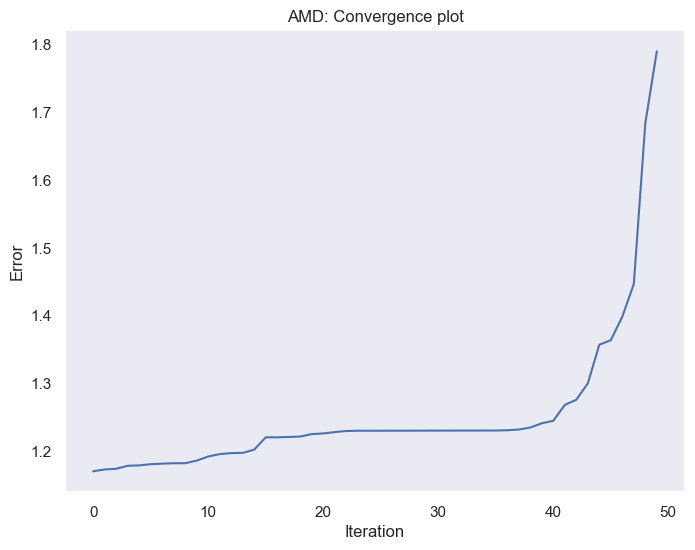

In [61]:
results = second_study.trials_dataframe()

results['value'].sort_values().reset_index(drop=True).plot()
plt.title(f'{run_supermodel_tmp.stock_code}: Convergence plot')
plt.xlabel('Iteration')
plt.ylabel('Error')

<b> saving just the best trial

In [62]:
run = MlflowClient().search_runs(
    experiment_ids=[exp_id],
    filter_string = f"tags.mlflow.runName LIKE '%{stock_code_name}-run-{today_str}%'",
    order_by = ["metrics.test_MSE ASC"],
    max_results=1,
)[0]

In [63]:
run_id = re.search('run_id(.*)artifact_path', run.data.tags['mlflow.log-model.history'])
best_run_id = re.search('": "(.*)", "', run_id.group(1))
best_run_id = best_run_id.group(1)

In [64]:
model_local_path = mlflow.artifacts.download_artifacts(
    run_id= best_run_id,
    artifact_path=f"{stock_code_name}-run"
)

best_model = mlflow.tensorflow.load_model(model_local_path)

In [65]:
def expected_return_plot_mlflow(self,model, plot = True, train_mean = train_mean , train_std = train_std , plot_col='stock_logdif'):

    data_ = wide_window.total_data[-wide_window.input_width:]
    data_ = (data_  - train_mean) / train_std
    data_ = data_.values
    data_ = data_.reshape((1,data_.shape[0],data_.shape[1]))
    plot_col_index = wide_window.column_indices[plot_col]
    
    if wide_window.label_columns:
        label_col_index = wide_window.label_columns_indices.get(plot_col, None)
    else:
        label_col_index = plot_col_index
        
    if plot:
        plt.figure(figsize=(8, 4))
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(wide_window.input_indices, data_[0, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

        predictions = model.predict(data_)
        plt.scatter(wide_window.label_indices, predictions[0, :, label_col_index],
                        marker='X', edgecolors='k', label='Predictions',
                        c='#ff7f0e', s=64)

        plt.xlabel('Time [d]')
        plt.axhline(0.0, linestyle='--', color = 'pink')
    return predictions

In [66]:
run_supermodel.expected_return_plot_mlflow = expected_return_plot_mlflow

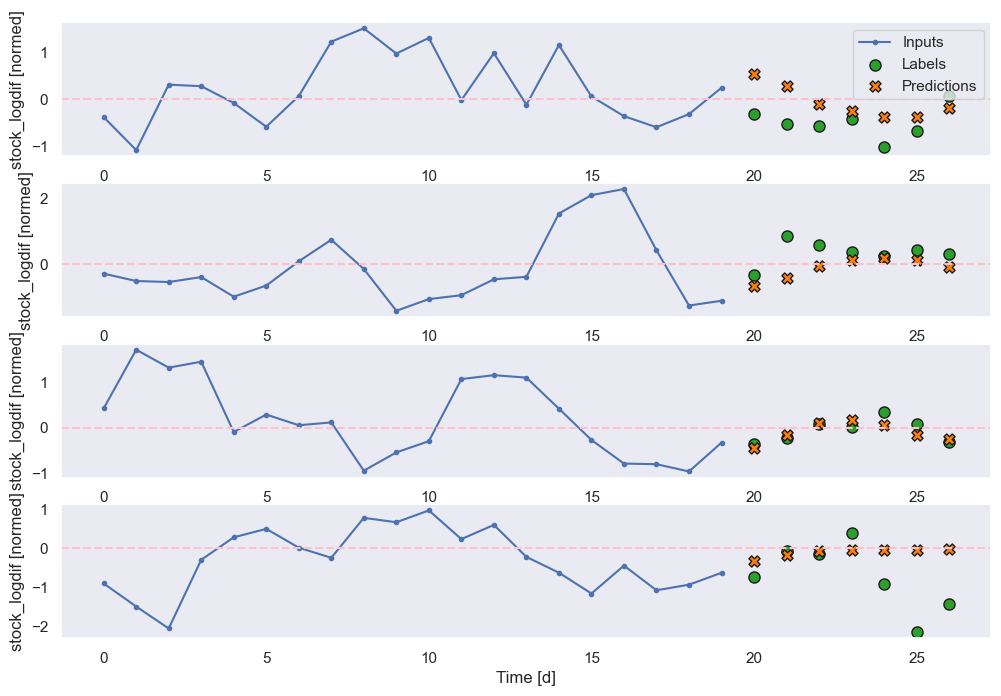

In [67]:
wide_window.plot(best_model)

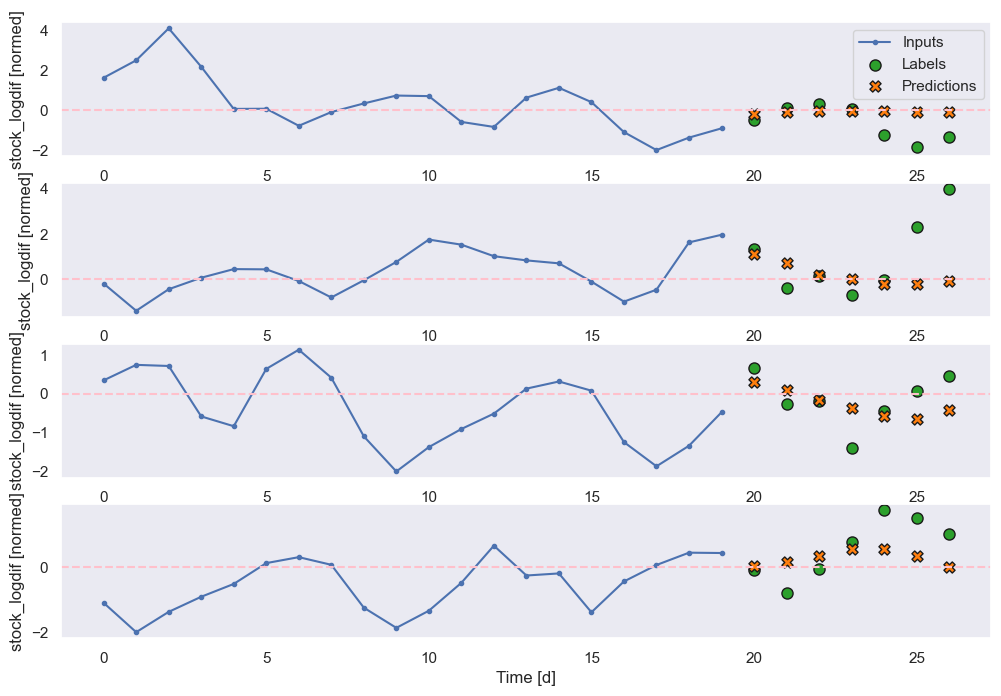

In [68]:
wide_window.plot_test(best_model)

1/1 [==============================] - 0s 132ms/step


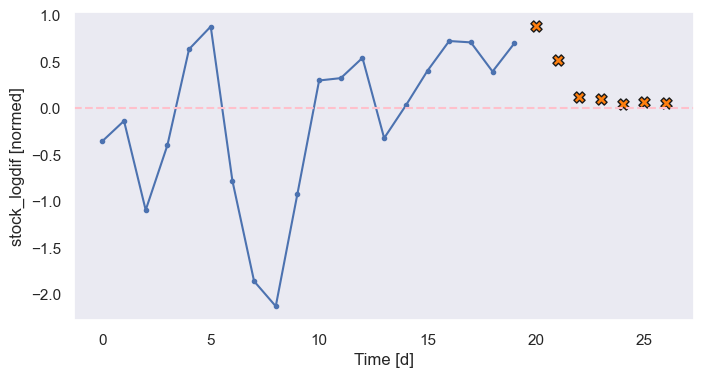

In [69]:
predictions = run_supermodel_tmp.expected_return_plot_mlflow(plot_col='stock_logdif', model = best_model)

In [70]:
second_study.best_params

{'conv_width': 4,
 'num_conv_layers': 1,
 'conv_1d_filters_0': 270,
 'conv_1d_activation_0': 'sigmoid',
 'dropout_0': 0.2,
 'num_dense_layers': 0,
 'optimizer_name': 'Adam',
 'learning_rate': 0.0013930809807582098}

In [71]:
with mlflow.start_run(run_id=best_run_id) as run:
    mlflow.log_param("study_best_params",second_study.best_params)

In [72]:
registered_model_name = f'{stock_code_name}_models'

try:
    client = MlflowClient()
    client.create_registered_model(registered_model_name)
except:
    print('folder already exists')

In [73]:
from mlflow.store.artifact.runs_artifact_repo import RunsArtifactRepository

desc = "A new version of the model"
runs_uri = "runs:/{}/{}-run".format(run.info.run_id,stock_code_name)
model_src = RunsArtifactRepository.get_underlying_uri(runs_uri)

mv = client.create_model_version(registered_model_name, model_src, run.info.run_id, description=desc)

2023/03/08 19:38:01 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: AMD_models, version 1


In [74]:
runs_uri

'runs:/e3fe9fe3a2b24e498b26c52a5d73c4bc/AMD-run'

<b> call model

In [75]:
client = MlflowClient()
for mv in client.search_model_versions(registered_model_name):
    print(dict(mv)['version'])

1
1


In [76]:
client = MlflowClient()
client.transition_model_version_stage(
    name=registered_model_name,
    version=1,
    stage="Production",
    archive_existing_versions = True
)

<ModelVersion: creation_timestamp=1678300681297, current_stage='Production', description='A new version of the model', last_updated_timestamp=1678300681553, name='AMD_models', run_id='e3fe9fe3a2b24e498b26c52a5d73c4bc', run_link=None, source='file:///C:/Users/Miguel/virgo/research_env/DS-2/mlruns/e3fe9fe3a2b24e498b26c52a5d73c4bc/artifacts/AMD-run', status='READY', status_message=None, tags={}, user_id=None, version=1>

In [77]:
latest_version_info = client.get_latest_versions(registered_model_name, stages=["Production"])
latest_production_version = latest_version_info[0].version
latest_production_version

1

In [78]:
model_version = latest_production_version

model = mlflow.pyfunc.load_model(
    model_uri=f"models:/{registered_model_name}/{model_version}"
)

In [79]:
def expected_return_plot_mlflow(self,model, plot = True, train_mean = train_mean , train_std = train_std , plot_col='stock_logdif'):

    data_ = self.total_data[-self.input_width:]
    data_ = (data_  - train_mean) / train_std
    data_ = data_.values
    data_ = data_.reshape((1,data_.shape[0],data_.shape[1]))
    plot_col_index = self.column_indices[plot_col]
    
    if self.label_columns:
        label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
        label_col_index = plot_col_index
        
    if plot:
        plt.figure(figsize=(8, 4))
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, data_[0, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

        predictions = model.predict(data_)
        plt.scatter(self.label_indices, predictions[0, :, label_col_index],
                        marker='X', edgecolors='k', label='Predictions',
                        c='#ff7f0e', s=64)

        plt.xlabel('Time [d]')
        plt.axhline(0.0, linestyle='--', color = 'pink')
    return predictions

In [80]:
datafunction.WindowGenerator.expected_return_plot_mlflow = expected_return_plot_mlflow

1/1 [==============================] - 0s 163ms/step


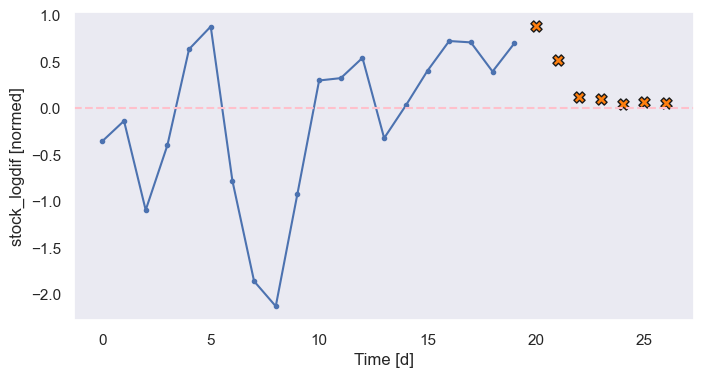

In [81]:
predictions = wide_window.expected_return_plot_mlflow(plot_col='stock_logdif', model = model)

In [82]:
def get_futur_prices(self,predictions,steps_futur, stock_code, plot = True, plot_col = 'stock_logdif', n_days = 14):
    
    index = self.label_columns_indices.get(plot_col, None)

    prep_predictions = {
        'Date': [ self.raw_stock['Date'].max() + relativedelta(days = i+1) for i in  range(OUT_STEPS)],
        'stock_price': [0]*steps_futur,
        'stock_stv': [0]*steps_futur,
        'stock_logdif': list(predictions[0,:,index]) 
    }
    prep_predictions = pd.DataFrame(prep_predictions)
    prep_predictions['stock_logdif'] = prep_predictions['stock_logdif'] * train_std[plot_col] + train_mean[plot_col]
    
    past_prices = self.raw_stock[-lag_days:]['stock_price'].values
    exp_returns = prep_predictions['stock_logdif'].values
    
    expt_price = list()

    for i in range(steps_futur):
        if i < len(past_prices):
            pred = np.exp(np.log(past_prices[i]) + exp_returns[i])
            expt_price.append(pred)
        else:
            j = i - len(past_prices)
            pred = np.exp(np.log(expt_price[j]) + exp_returns[i])
            expt_price.append(pred)
            
    prep_predictions['stock_price'] = expt_price
    prep_predictions['Type'] = 'Forecast'
    prep_predictions['StockCode'] = stock_code
    
    some_history = self.raw_stock[-(lag_days+n_days):].copy()
    some_history['Type'] = 'History'
    some_history['StockCode'] = stock_code
    
    final_ = pd.concat([some_history, prep_predictions]).reset_index(drop = True)
    final_ = final_[['Date','stock_price','Type','StockCode']]
    final_['ExecutionDate'] = pd.Timestamp.today().strftime('%Y-%m-%d')
    final_ = final_[-(steps_futur+4):]
    
    if plot:
        plt.figure(figsize=(10, 4))
        plt.ylabel(f'stock price')
        plt.plot(some_history.Date, some_history.stock_price, label='Inputs', marker='.', zorder=-10)
        plt.scatter(prep_predictions.Date, prep_predictions.stock_price,marker='X', edgecolors='k', label='Predictions',c='#ff7f0e', s=64)
        plt.xlabel('date')
    
    return final_

In [83]:
datafunction.WindowGenerator.get_futur_prices = get_futur_prices

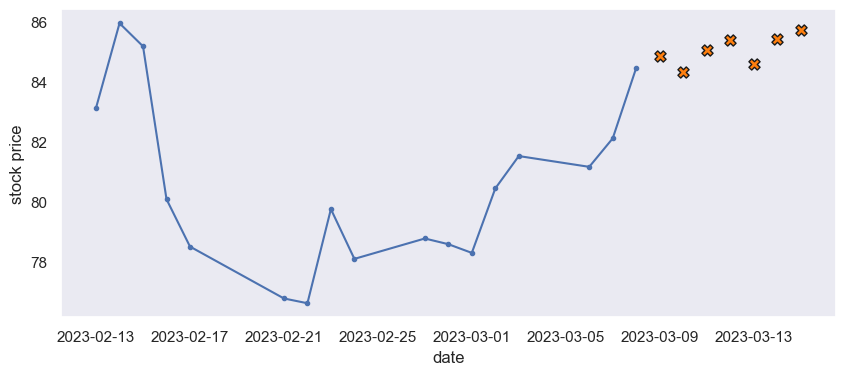

In [84]:
final_result = wide_window.get_futur_prices(predictions= predictions ,steps_futur = OUT_STEPS, stock_code= stock_code_name)

<b>changes:
* drop th drop columns configs
* split function in super model to get raw data and configs
* OUT_STEPS remove from configs and set it as a variable